In [ ]:
import torch
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [ ]:
torch.set_default_device('cuda')

In [ ]:
alpha_Z = 1
alpha_A = 1
alpha_Z_t = 1
alpha_A_t = 1
tau_e = 1
tau_A = 1
tau_A_t = 1

In [ ]:
n = 1000
d = 500

In [ ]:
def generate_angle_vector(beta_star, angle_degrees):
  """
  Generates a unit-norm vector at a specified angle to beta_star.

  Args:
    beta_star: The input vector.
    angle_degrees: The desired angle in degrees.

  Returns:
    A unit-norm vector at the specified angle to beta_star.
  """
  # Generate a random vector
  random_vector = torch.randn(beta_star.shape)

  # Orthogonalize the random vector to beta_star using Gram-Schmidt
  orthogonal_vector = random_vector - (torch.dot(random_vector, beta_star) / torch.dot(beta_star, beta_star)) * beta_star

  # Normalize the orthogonal vector
  orthogonal_vector = orthogonal_vector / torch.norm(orthogonal_vector)

  # Convert angle to radians
  angle_radians = torch.deg2rad(torch.tensor(angle_degrees))

  # Create the angled vector
  angled_vector = torch.cos(angle_radians) * (beta_star / torch.norm(beta_star)) + torch.sin(angle_radians) * orthogonal_vector

  return angled_vector

# General Framework

In [ ]:
def gen_variables(n, d, tau_A, tau_A_t,  tau_e = 1, alpha_Z_t = None, alpha_A_t = None, alpha_Z = None, alpha_A = None,
                  beta_star = None, u = None, large = True):
  """
    Generates variables based on the model described in Section 2 of the paper
    and includes calculations needed for Lemmas in the paper.
  """

  if alpha_Z is None:
    alpha_Z = 1 #torch.rand(1)*5
  if alpha_A is None:
    alpha_A = 2 #torch.rand(1)*5
  if alpha_Z_t is None:
    alpha_Z_t = 3 #torch.rand(1)*5
  if alpha_A_t is None:
    alpha_A_t = 4 #torch.rand(1)*5

  A = tau_A * torch.randn(d,n)/np.sqrt(d)
  A_t = tau_A_t * torch.randn(d,n)/np.sqrt(d) # Corresponds to \tilde{A} in paper

  Ap = torch.linalg.pinv(A)
  Ap_t = torch.linalg.pinv(A_t)

  if u is None:
    u = torch.randn(d,1)
    u = u/torch.norm(u)

  v = torch.randn(n,1)
  v = v/torch.norm(v)

  v_t = torch.randn(n,1)
  v_t = v_t/torch.norm(v_t) # Corresponds to \tilde{v}

  # Spike strength parameters
  if large:
    theta = np.sqrt(n) * tau_A
    theta_t = np.sqrt(n) * tau_A_t
  else:
    theta = 1 * tau_A
    theta_t = 1 * tau_A_t

  Z = theta * u @ v.T
  Z_t = theta_t * u @ v_t.T

  X = Z + A

  h = v.T @ Ap
  k = Ap @ u
  t = v.T @ (torch.eye(n) - Ap @ A)
  s = (torch.eye(d) - A @ Ap) @ u
  xi = 1 + theta * v.T @ Ap @ u

  knorm_sq = torch.norm(k)**2
  hnorm_sq = torch.norm(h)**2
  tnorm_sq = torch.norm(t)**2
  snorm_sq = torch.norm(s)**2

  gamma_1 = theta**2 * tnorm_sq * knorm_sq + xi ** 2
  gamma_2 = theta**2 * snorm_sq * hnorm_sq + xi ** 2

  p1 = - (theta**2 * knorm_sq)/(xi) * t.T - theta * k
  p2 = - (theta**2 * snorm_sq)/(xi) * Ap @ h.T - theta * k

  q1_T = - (theta * tnorm_sq)/(xi) * k.T @ Ap - h
  q2_T = - (theta * hnorm_sq)/(xi) * s.T - h

  if beta_star is None:
    beta_star = torch.randn(d,1)

  # U,S,Vh = torch.linalg.svd(X, full_matrices=False)
  # Xp = Vh.T @ torch.diag(1/S) @ U.T
  Xp = torch.linalg.pinv(X)

  epsilon = tau_e * torch.randn(n, 1)

  beta_so_T = (alpha_Z * beta_star.T @ Z + epsilon.T) @ Xp
  beta_int_T = beta_so_T + alpha_A * beta_star.T @ A @ Xp

  return {
      'k': k,
      'h': h,
      't': t,
      's': s,
      'p1': p1,
      'p2': p2,
      'q1': q1_T.T,
      'q2': q2_T.T,
      'gamma_1': gamma_1,
      'gamma_2': gamma_2,
      'xi': xi.item(),
      'hnorm_sq': hnorm_sq,
      'tnorm_sq': tnorm_sq,
      'snorm_sq': snorm_sq,
      'knorm_sq': knorm_sq,
      'theta': theta,
      'theta_t': theta_t,
      'X': X,
      'Z': Z,
      'Z_t': Z_t,
      'A': A,
      'A_t': A_t,
      'Ap': Ap,
      'Ap_t': Ap_t,
      'u': u,
      'v': v,
      'v_t': v_t,
      'beta_star': beta_star,
      'epsilon': epsilon,
      'Xp': Xp,
      'alpha_Z': alpha_Z,
      'alpha_A': alpha_A,
      'alpha_Z_t': alpha_Z_t,
      'alpha_A_t': alpha_A_t,
      'beta_so': beta_so_T.T,
      'beta_int': beta_int_T.T,
      'tau_e': tau_e,
      'tau_A': tau_A
  }

def test_betaTu(f_emp, f_theory, T = 50, Ns = [100,200,300,400,450,550,600,700,800,900,1000], d = 500, beta_star = None, u = None):
  emp_error = torch.zeros(len(Ns),2)
  theory_error = torch.zeros(len(Ns),2)
  if beta_star is None:
    beta_star = torch.randn(d,1)
    beta_star = beta_star/torch.norm(beta_star)
  if u is None:
    u = torch.randn(d,1)
    u = u/torch.norm(u)
  for i,n in tqdm(list(enumerate(Ns))):
    emp_error[i,0] = f_emp(n,d,1,beta_star,u,T=T)
    emp_error[i,1] = f_emp(n,d,np.sqrt(n),beta_star,u,T=T)

    theory_error[i,0] = f_theory(n,d,1,beta_star,u)
    theory_error[i,1] = f_theory(n,d,np.sqrt(n),beta_star,u)

  return emp_error.cpu(), theory_error.cpu()

def test(f_emp, f_theory, Ns = [100,200,300,400,450,550,600,700,800,900,1000], d = 500):
  emp_error = torch.zeros(len(Ns),2)
  theory_error = torch.zeros(len(Ns),2)
  for i,n in tqdm(list(enumerate(Ns))):
    emp_error[i,0] = f_emp(n,d,1)
    emp_error[i,1] = f_emp(n,d,np.sqrt(n))

    theory_error[i,0] = f_theory(n,d,1)
    theory_error[i,1] = f_theory(n,d,np.sqrt(n))

  return emp_error.cpu(), theory_error.cpu()

def test_la(f_emp, f_theory, Ns = [100,200,300,400,450,550,600,700,800,900,1000], d = 500):
  error = torch.zeros(len(Ns),2)
  for i,n in tqdm(list(enumerate(Ns))):
    vars = gen_variables(n,d,1,1)
    emp = f_emp(vars)
    theory = f_theory(vars)
    error[i,0] = (emp - theory).norm()/(emp.norm())

    vars = gen_variables(n,d,np.sqrt(n),np.sqrt(n))
    emp = f_emp(vars)
    theory = f_theory(vars)
    error[i,1] = (emp - theory).norm()/(emp.norm())

  return error.cpu()

In [ ]:
gen_variables(n,d,1,1);

# Lemmas

## Lemma 1

### H norm

  0%|          | 0/11 [00:00<?, ?it/s]

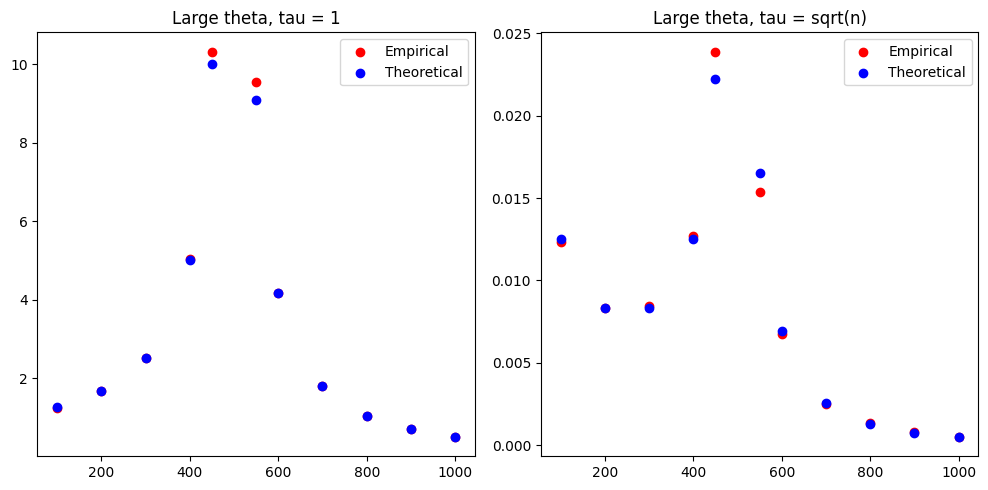

Relative Errors: tensor(0.0176) tensor(0.0208) tensor(0.0733)


In [ ]:
def hnorm_emp(n, d, tau, T = 50):
  avg = 0
  for t in range(T):
    vars = gen_variables(n,d,tau,tau)
    avg += vars['hnorm_sq']
  return avg/T

def hnorm_theory(n,d,tau):
  c = d/n
  if c < 1:
    return (c**2)/((1-c) * tau**2)
  else:
    return (c)/((c-1) * tau**2)

def hnorm_test():
  Ns = [100,200,300,400,450,550,600,700,800,900,1000]
  emp_error, theory_error = test(hnorm_emp, hnorm_theory)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('Large theta, tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('Large theta, tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

hnorm_test()

### k norm

  0%|          | 0/11 [00:00<?, ?it/s]

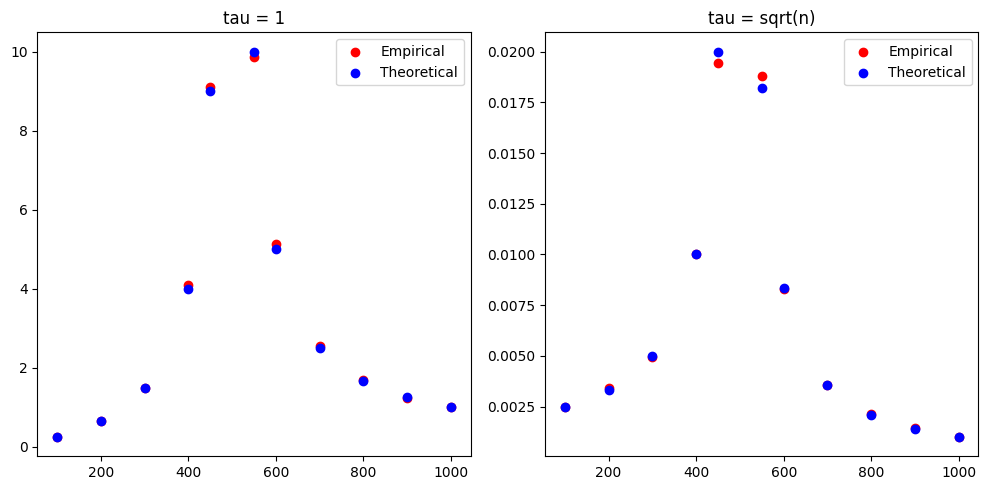

Relative Errors: tensor(0.0155) tensor(0.0100) tensor(0.0330)


In [ ]:
def knorm_emp(n, d, tau, T = 50):
  avg = 0
  for t in range(T):
    vars = gen_variables(n,d,tau,tau)
    avg += vars['knorm_sq']
  return avg/T

def knorm_theory(n,d,tau):
  c = d/n
  if c < 1:
    return (c)/((1-c) * tau**2)
  else:
    return (1)/((c-1) * tau**2)

def knorm_test():
  Ns = [100,200,300,400,450,550,600,700,800,900,1000]
  emp_error, theory_error = test(knorm_emp, knorm_theory)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

knorm_test()

### t norm

  0%|          | 0/6 [00:00<?, ?it/s]

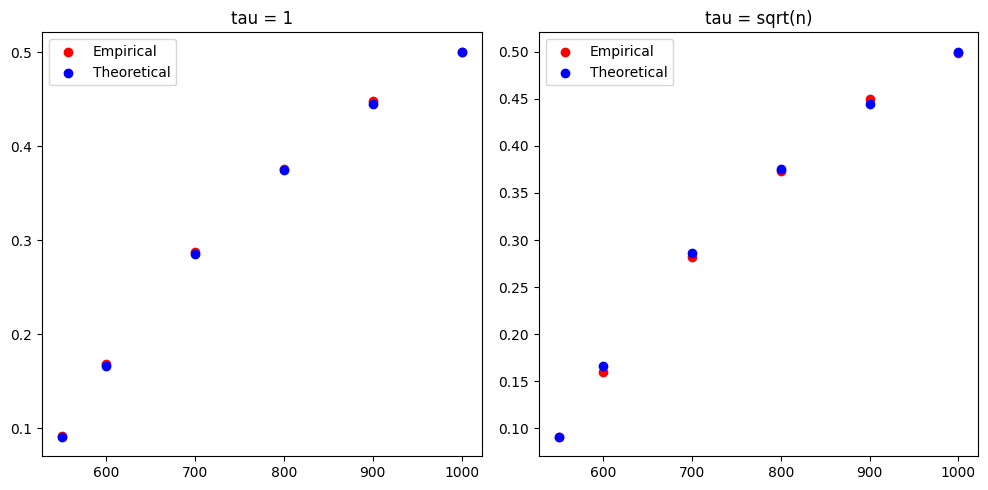

Relative Errors: tensor(0.0100) tensor(0.0120) tensor(0.0451)


In [ ]:
def tnorm_emp(n, d, tau, T = 50):
  avg = 0
  for t in range(T):
    vars = gen_variables(n,d,tau,tau)
    avg += vars['tnorm_sq']
  return avg/T

def tnorm_theory(n,d,tau):
  c = d/n
  if c < 1:
    return 1-c
  else:
    return 0

def tnorm_test():
  Ns = [550,600,700,800,900,1000]
  emp_error, theory_error = test(tnorm_emp, tnorm_theory, Ns=Ns)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

tnorm_test()

### s norm

  0%|          | 0/5 [00:00<?, ?it/s]

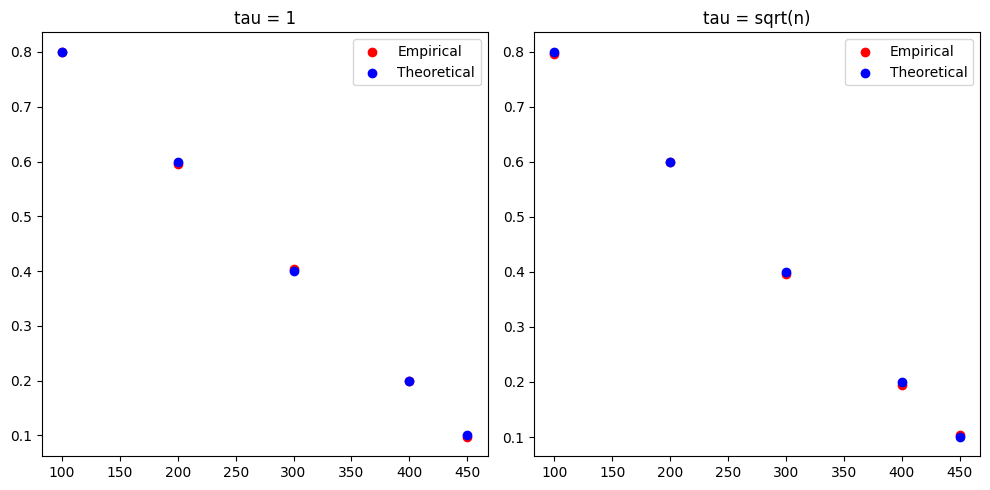

Relative Errors: tensor(0.0130) tensor(0.0140) tensor(0.0373)


In [ ]:
def snorm_emp(n, d, tau, T = 50):
  avg = 0
  for t in range(T):
    vars = gen_variables(n,d,tau,tau)
    avg += vars['snorm_sq']
  return avg/T

def snorm_theory(n,d,tau):
  c = d/n
  if c < 1:
    return 0
  else:
    return 1-1/c

def snorm_test():
  Ns = [100,200,300,400,450]
  emp_error, theory_error = test(snorm_emp, snorm_theory, Ns=Ns)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

snorm_test()

### xi/theta

  0%|          | 0/11 [00:00<?, ?it/s]

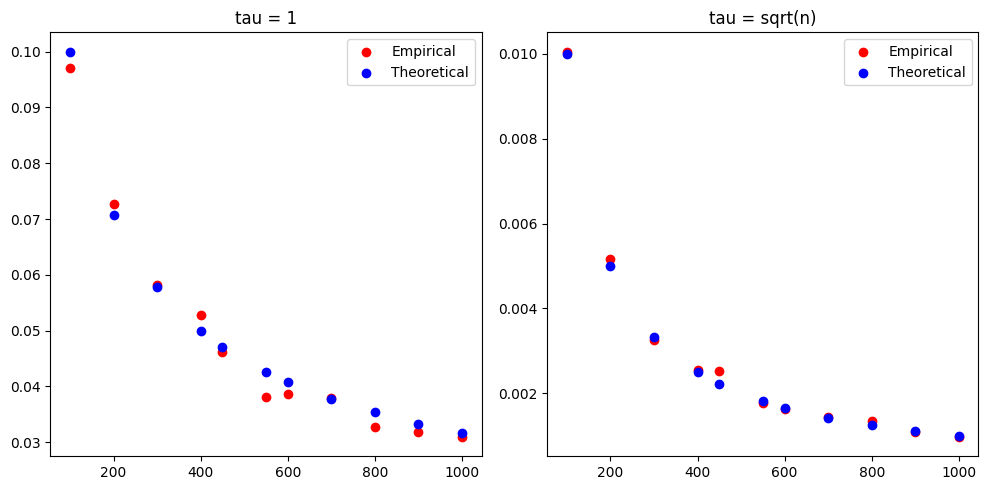

Relative Errors: tensor(0.0386) tensor(0.0331) tensor(0.1216)


In [ ]:
def xi_theta_emp(n, d, tau, T = 1000):
  avg = 0
  for t in range(T):
    vars = gen_variables(n,d,tau,tau)
    avg += vars['xi']/vars['theta']
  return avg/T

def xi_theta_theory(n,d,tau):
  theta = np.sqrt(n) * tau
  return 1/theta

def xi_theta_test():
  Ns = [100,200,300,400,450,550,600,700,800,900,1000]
  emp_error, theory_error = test(xi_theta_emp, xi_theta_theory)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

xi_theta_test()

  0%|          | 0/11 [00:00<?, ?it/s]

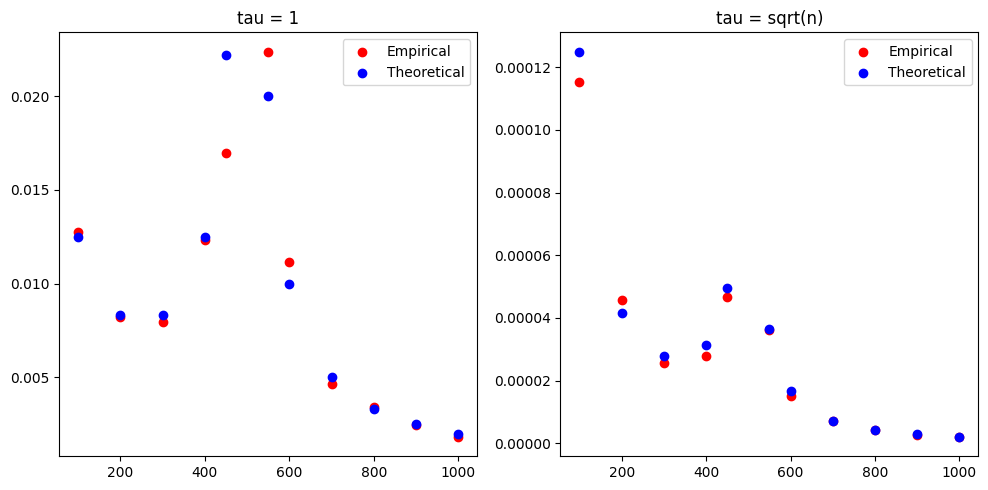

Relative Errors: tensor(0.0669) tensor(0.0676) tensor(0.3087)


In [ ]:
def xi_theta_sq_emp(n, d, tau, T = 250):
  avg = 0
  for t in range(T):
    vars = gen_variables(n,d,tau,tau)
    avg += (vars['xi']/vars['theta'])**2
  return avg/T

def xi_theta_sq_theory(n,d,tau):
  theta = np.sqrt(n) * tau
  c = d/n
  return 1/(theta**2) + (c/np.abs(1-c) * (1/tau**2) * 1/np.maximum(n,d))

def xi_theta_sq_test():
  Ns = [100,200,300,400,450,550,600,700,800,900,1000]
  emp_error, theory_error = test(xi_theta_sq_emp, xi_theta_sq_theory)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

xi_theta_sq_test()

## Lemma 2

  0%|          | 0/11 [00:00<?, ?it/s]

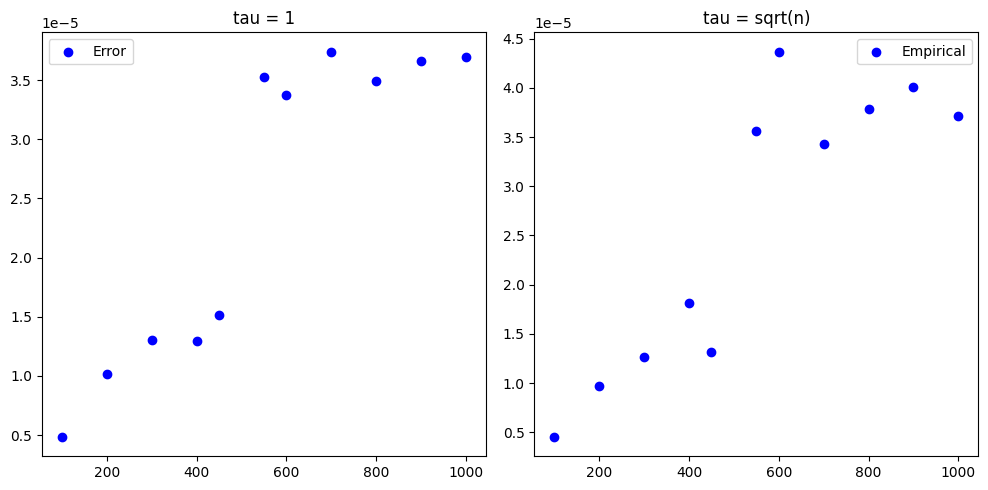

Relative Errors: tensor(2.5361e-05) tensor(1.3459e-05) tensor(4.3680e-05)


In [ ]:
def lem2_lhs(vars):
  return vars['Xp'] @ vars['Z_t']

def lem2_rhs(vars):
  n, d = vars['A'].shape[1], vars['A'].shape[0]
  if n > d:
    return -1*vars['theta_t'] * vars['xi'] * vars['p1'] @ vars['v_t'].T / (vars['gamma_1'] * vars['theta'])
  else:
    return -1*vars['theta_t'] * vars['xi'] * vars['p2'] @ vars['v_t'].T / (vars['gamma_2'] * vars['theta'])

def lem2_test():
  Ns = [100,200,300,400,450,550,600,700,800,900,1000]
  error = test_la(lem2_lhs, lem2_rhs)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, error[:,0], color = 'blue', label='Error')
  axs[0].set_title('tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, error[:,1], color = 'blue', label='Empirical')
  axs[1].set_title('tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  print("Relative Errors:", error.mean(), error.std(), error.max())

lem2_test()

## Lemma 3

  0%|          | 0/11 [00:00<?, ?it/s]

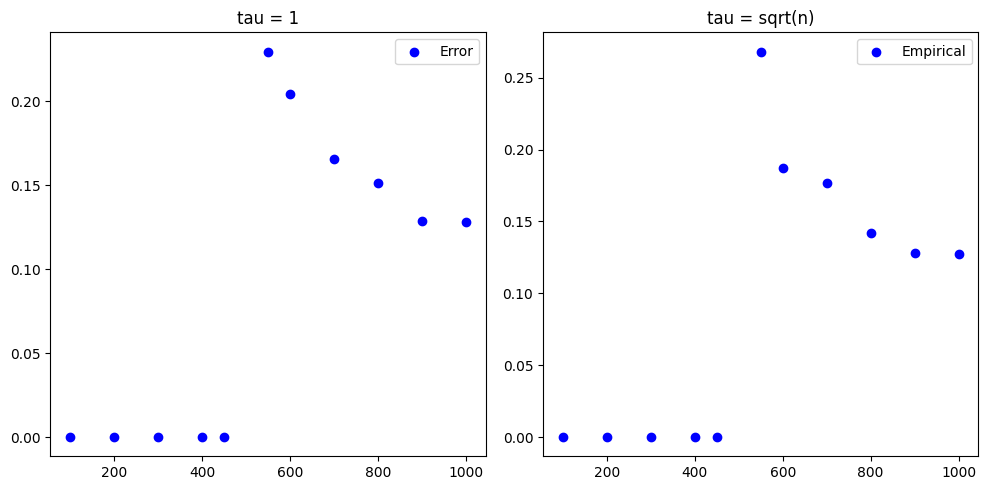

Relative Errors: tensor(0.0927) tensor(0.0926) tensor(0.2682)


In [ ]:
def lem3_lhs(vars):
  return vars['A'] @ vars['Xp']

def lem3_rhs(vars):
  n, d = vars['A'].shape[1], vars['A'].shape[0]
  if n > d:
    return torch.eye(d) - vars['theta'] * vars['xi'] * vars['u'] @ vars['h'] / (vars['gamma_1']) + vars['theta']**2 * vars['tnorm_sq'] * vars['u'] @ vars['k'].T @ vars['Ap'] / (vars['gamma_1'])
  else:
    term1 = vars['A'] @ vars['Ap']
    term2 = vars['theta'] * vars['xi'] * vars['h'].T @ vars['s'].T / (vars['gamma_2'])
    term3 = vars['theta']**2 * vars['snorm_sq'] * vars['h'].T @ vars['h'] / (vars['gamma_2'])
    term4 = vars['theta']**2 * vars['hnorm_sq'] * vars['A'] @ vars['Ap'] @ vars['u'] @ vars['s'].T / (vars['gamma_2'])
    term5 = vars['theta'] * vars['xi'] * vars['A'] @ vars['Ap'] @ vars['u'] @ vars['h'] / (vars['gamma_2'])
    return term1 + term2 - term3 - term4 - term5

def lem3_test():
  Ns = [100,200,300,400,450,550,600,700,800,900,1000]
  error = test_la(lem3_lhs, lem3_rhs)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, error[:,0], color = 'blue', label='Error')
  axs[0].set_title('tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, error[:,1], color = 'blue', label='Empirical')
  axs[1].set_title('tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  print("Relative Errors:", error.mean(), error.std(), error.max())


lem3_test()

## Lemma 4

  0%|          | 0/11 [00:00<?, ?it/s]

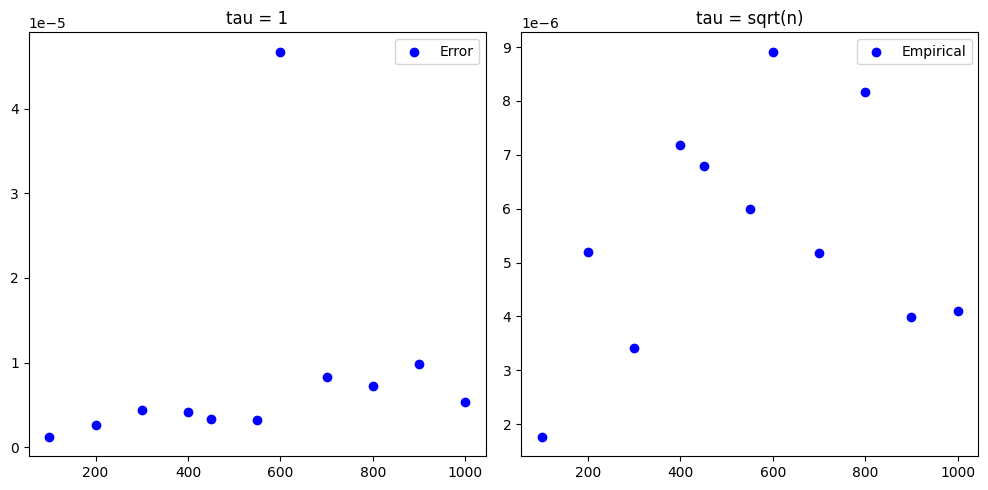

Relative Errors: tensor(7.1331e-06) tensor(9.1456e-06) tensor(4.6723e-05)


In [ ]:
def lem4_lhs(vars):
    beta_star_T = vars['beta_star'].T
    return beta_star_T @ vars['Z'] @ vars['Xp'] @ vars['Z_t']

def lem4_rhs(vars):
    n, d = vars['A'].shape[1], vars['A'].shape[0]
    c = d/n
    beta_star_T = vars['beta_star'].T # shape (1, d)

    if c < 1: # Case c < 1 (d < n)
        coeff = (1 - vars['xi'] / vars['gamma_1'])
    else: # Case c > 1 (d > n)
        coeff = (1 - vars['xi'] / vars['gamma_2'])

    return coeff * beta_star_T @ vars['Z_t']

def lem4_test():
  Ns = [100,200,300,400,450,550,600,700,800,900,1000]
  error = test_la(lem4_lhs, lem4_rhs)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, error[:,0], color = 'blue', label='Error')
  axs[0].set_title('tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, error[:,1], color = 'blue', label='Empirical')
  axs[1].set_title('tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  print("Relative Errors:", error.mean(), error.std(), error.max())

lem4_test()

## Lemma 5

  0%|          | 0/11 [00:00<?, ?it/s]

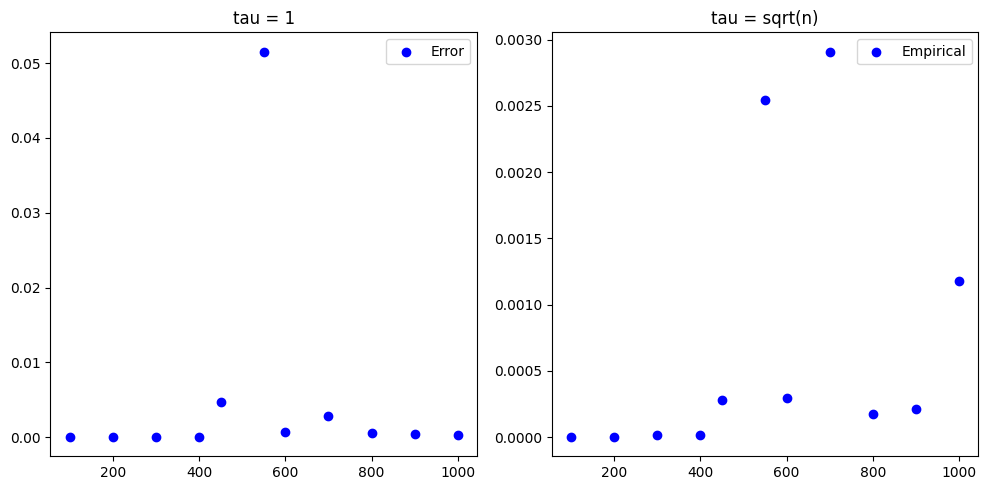

Relative Errors: tensor(0.0031) tensor(0.0109) tensor(0.0516)


In [ ]:
def lem5_lhs(vars):
    beta_star_T = vars['beta_star'].T
    result = beta_star_T @ vars['A'] @ vars['Xp'] @ vars['Z_t']
    return result

def lem5_rhs(vars):
    n, d = vars['A'].shape[1], vars['A'].shape[0]
    c = d/n
    beta_star_T = vars['beta_star'].T # shape (1, d)
    beta_star_T_Zt = beta_star_T @ vars['Z_t'] # (1xd)@(dxn) -> (1xn)

    if c < 1: # Case c < 1 (d < n) [cite: 47]
        coeff = vars['xi'] / vars['gamma_1']
        result = coeff * beta_star_T_Zt
    else: # Case c > 1 (d > n) [cite: 50]

        term1_coeff = vars['theta'] * vars['snorm_sq'] / vars['gamma_2']
        term1 = term1_coeff * beta_star_T @ vars['h'].T @ vars['u'].T @ vars['Z_t']

        term2_coeff = vars['xi'] / vars['gamma_2']
        term2 = term2_coeff * beta_star_T @ vars['A'] @ vars['Ap'] @ vars['Z_t']

        result = term1 + term2
    return result

def lem5_test():
  Ns = [100,200,300,400,450,550,600,700,800,900,1000]
  error = test_la(lem5_lhs, lem5_rhs)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, error[:,0], color = 'blue', label='Error')
  axs[0].set_title('tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, error[:,1], color = 'blue', label='Empirical')
  axs[1].set_title('tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  print("Relative Errors:", error.mean(), error.std(), error.max())

lem5_test()

## Lemma 6

  0%|          | 0/11 [00:00<?, ?it/s]

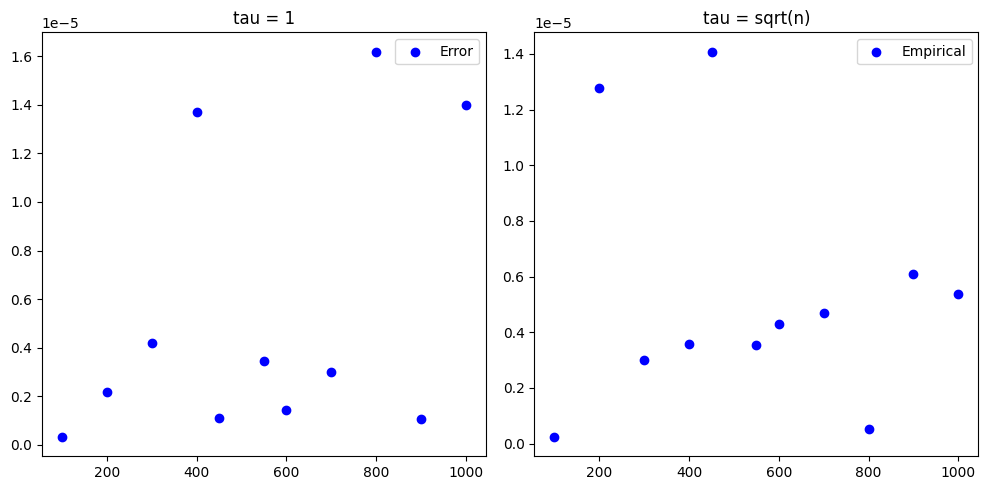

Relative Errors: tensor(5.4018e-06) tensor(5.1427e-06) tensor(1.6199e-05)


In [ ]:
def lem6_lhs(vars):
  alpha_Z_t = vars['alpha_Z_t']
  beta_star_T = vars['beta_star'].T # shape (1, d)

  term1 = alpha_Z_t * beta_star_T @ vars['Z_t'] # (1xn)
  term2 = vars['beta_int'].T @ vars['Z_t'] # (1xd)@(dxn) -> (1xn)
  return term1 - term2

def lem6_rhs(vars):
  n, d = vars['A'].shape[1], vars['A'].shape[0]
  c = d/n
  beta_star_T = vars['beta_star'].T # shape (1, d)
  if c < 1:
    coeff = vars['alpha_Z_t'] - vars['alpha_Z'] + (vars['xi'] / vars['gamma_1']) * (vars['alpha_Z'] - vars['alpha_A'])
    term1 = coeff * beta_star_T @ vars['Z_t']

    coeff2 = (vars['theta_t']/vars['theta']) * (vars['xi'] / vars['gamma_1'])
    term2 = coeff2 * vars['epsilon'].T @ vars['p1'] @ vars['v_t'].T
    # return vars['alpha_Z_t'] * beta_star_T @ vars['Z_t'] - vars['alpha_Z'] * lem4_rhs(vars) - vars['alpha_A'] * lem5_rhs(vars) - vars['epsilon'].T @ lem2_rhs(vars)
    return term1 + term2
  else:
    term1_a = (vars['alpha_Z_t'] - vars['alpha_Z']) * torch.eye(d)
    term1_b = (vars['xi'] / vars['gamma_2']) * (vars['alpha_Z'] * torch.eye(d) - vars['alpha_A'] * vars['A'] @ vars['Ap'])
    term1 = vars['beta_star'].T @ (term1_a + term1_b) @ vars['Z_t']

    term2 = vars['alpha_A'] * vars['theta'] * vars['snorm_sq']/vars['gamma_2'] * vars['beta_star'].T @ vars['h'].T @ vars['u'].T @ vars['Z_t']

    term3 = (vars['theta_t']/vars['theta']) * (vars['xi'] / vars['gamma_2']) * vars['epsilon'].T @ vars['p2'] @ vars['v_t'].T

    # return vars['alpha_Z_t'] * beta_star_T @ vars['Z_t'] - vars['alpha_Z'] * lem4_rhs(vars) - vars['alpha_A'] * lem5_rhs(vars) - vars['epsilon'].T @ lem2_rhs(vars)
    return term1 - term2 + term3

def lem6_test():
  Ns = [100,200,300,400,450,550,600,700,800,900,1000]
  error = test_la(lem6_lhs, lem6_rhs, Ns = Ns)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, error[:,0], color = 'blue', label='Error')
  axs[0].set_title('tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, error[:,1], color = 'blue', label='Empirical')
  axs[1].set_title('tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  print("Relative Errors:", error.mean(), error.std(), error.max())

lem6_test()

## Lemma 7

  0%|          | 0/6 [00:00<?, ?it/s]

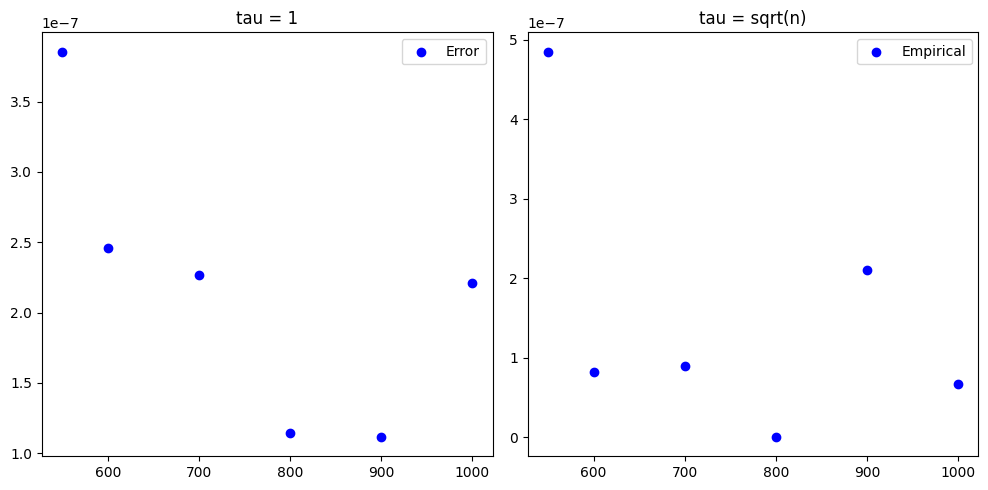

Relative Errors: tensor(1.8650e-07) tensor(1.4022e-07) tensor(4.8506e-07)


In [ ]:
def lem7_p1_lhs(vars):
  return torch.norm(vars['p1'])**2

def lem7_p1_rhs(vars):
  n, d = vars['A'].shape[1], vars['A'].shape[0]
  c = d/n
  return vars['theta']**2 * vars['knorm_sq'] / vars['xi']**2 * vars['gamma_1']

def lem7_p1_test():
  Ns = [550,600,700,800,900,1000]
  error = test_la(lem7_p1_lhs, lem7_p1_rhs, Ns = Ns)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, error[:,0], color = 'blue', label='Error')
  axs[0].set_title('tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, error[:,1], color = 'blue', label='Empirical')
  axs[1].set_title('tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  print("Relative Errors:", error.mean(), error.std(), error.max())

lem7_p1_test()

  0%|          | 0/5 [00:00<?, ?it/s]

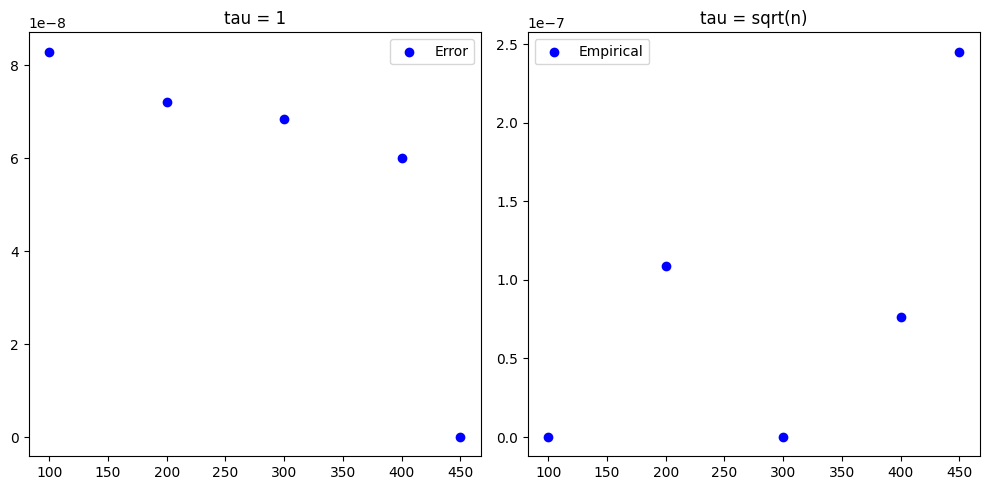

Relative Errors: tensor(7.1380e-08) tensor(7.2408e-08) tensor(2.4522e-07)


In [ ]:
def lem7_p2_lhs(vars):
  return torch.norm(vars['p2'])**2

def lem7_p2_rhs(vars):

  term1 = vars['theta']**4 * vars['snorm_sq']**2 / vars['xi']**2 * (vars['Ap'] @ vars['h'].T).square().sum()
  term2 = 2 * vars['theta']**3 * vars['snorm_sq'] / vars['xi'] * vars['h'] @ vars['Ap'].T @ vars['k']
  term3 = vars['theta']**2 * vars['knorm_sq']
  return term1 + term2 + term3

def lem7_p2_test():
  Ns = [100,200,300,400,450]
  error = test_la(lem7_p2_lhs, lem7_p2_rhs, Ns = Ns)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, error[:,0], color = 'blue', label='Error')
  axs[0].set_title('tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, error[:,1], color = 'blue', label='Empirical')
  axs[1].set_title('tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  print("Relative Errors:", error.mean(), error.std(), error.max())

lem7_p2_test()

## Lemma 8

  0%|          | 0/6 [00:00<?, ?it/s]

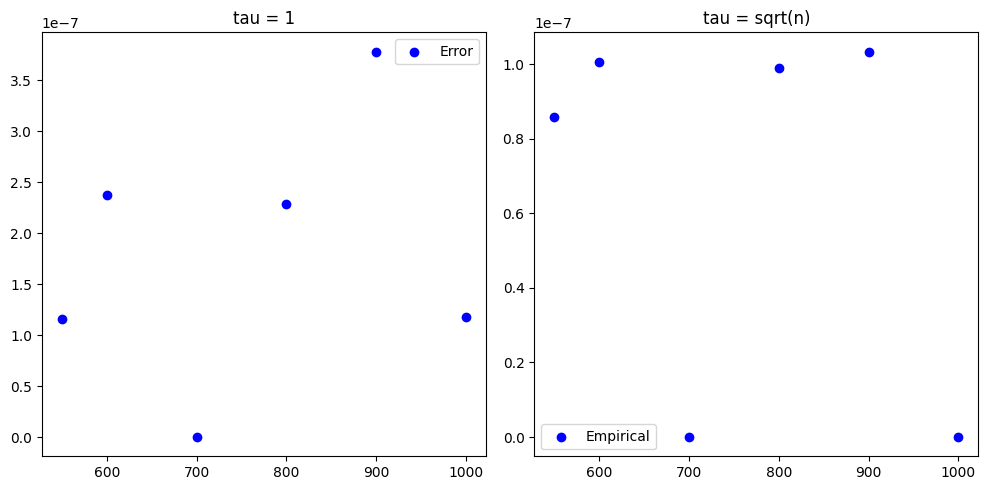

Relative Errors: tensor(1.2215e-07) tensor(1.1185e-07) tensor(3.7802e-07)


In [ ]:
def lem8_q1_lhs(vars):
    return torch.norm(vars['q1'])**2

def lem8_q1_rhs(vars):
  term1 = vars['theta']**2 * vars['tnorm_sq']**2 / vars['xi']**2 * vars['k'].T @ vars['Ap'] @ vars['Ap'].T @ vars['k']
  term2 = 2 * vars['theta'] * vars['tnorm_sq'] / vars['xi'] * vars['k'].T @ vars['Ap'] @ vars['h'].T
  term3 = vars['hnorm_sq']

  return term1 + term2 + term3

def lem8_q1_test():
  Ns = [550,600,700,800,900,1000]
  error = test_la(lem8_q1_lhs, lem8_q1_rhs, Ns = Ns)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, error[:,0], color = 'blue', label='Error')
  axs[0].set_title('tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, error[:,1], color = 'blue', label='Empirical')
  axs[1].set_title('tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  print("Relative Errors:", error.mean(), error.std(), error.max())

lem8_q1_test()


  0%|          | 0/5 [00:00<?, ?it/s]

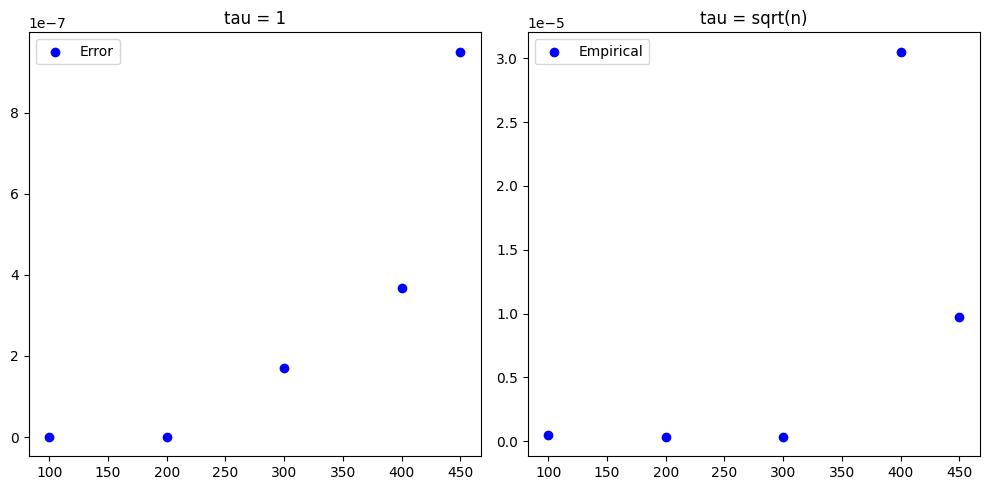

Relative Errors: tensor(4.2842e-06) tensor(9.6851e-06) tensor(3.0528e-05)


In [ ]:
def lem8_q2_lhs(vars):
    return torch.norm(vars['q2'])**2

def lem8_q2_rhs(vars):
    term1 = vars['theta']**2 * vars['hnorm_sq']**2 * vars['snorm_sq'] / vars['xi']**2
    term2 = 2 * vars['theta']**2 * vars['hnorm_sq'] / vars['xi'] * vars['h'] @ vars['s']
    term3 = vars['hnorm_sq']
    return term1 + term2 + term3

def lem8_q2_test():
  Ns = [100,200,300,400,450]
  error = test_la(lem8_q2_lhs, lem8_q2_rhs, Ns = Ns)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, error[:,0], color = 'blue', label='Error')
  axs[0].set_title('tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, error[:,1], color = 'blue', label='Empirical')
  axs[1].set_title('tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  print("Relative Errors:", error.mean(), error.std(), error.max())

lem8_q2_test()

## Lemma 9

## Lemma 10

  0%|          | 0/6 [00:00<?, ?it/s]

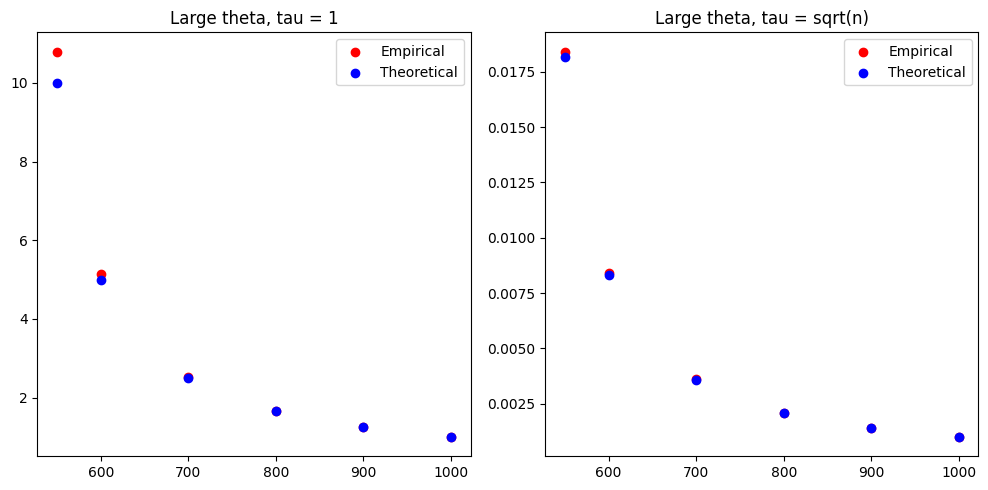

Relative Errors: tensor(0.0154) tensor(0.0199) tensor(0.0738)


In [ ]:
def lem10_1_emp(n, d, tau, beta_star, u, T = 50):
  avg = 0
  for t in range(T):
    vars = gen_variables(n,d,tau,tau, beta_star = beta_star, u = u)
    beta_star_T = vars['beta_star'].T
    ApT = vars['Ap'].T
    beta_star_T_u = beta_star_T @ vars['u']
    beta_star_T_ApT_k = beta_star_T @ ApT @ vars['k']
    avg += vars['beta_star'].T @ vars['u'] @ vars['k'].T @ vars['Ap'] @ vars['beta_star']
  return avg/T

def lem10_1_theory(n, d, tau, beta_star, u): # Calculate c/(tau^2(1-c)) (beta*^T u)^2
    beta_star_T_u = beta_star.T @ u
    c = d/n
    coeff = c / (tau**2 * (1-c))
    return coeff * beta_star_T_u**2

def lem10_1_test():
  Ns = [550,600,700,800,900,1000]
  beta_star = torch.randn(d,1)
  beta_star = beta_star / beta_star.norm()

  u = beta_star
  emp_error, theory_error = test_betaTu(lem10_1_emp, lem10_1_theory, Ns=Ns, beta_star = beta_star, u = u)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('Large theta, tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('Large theta, tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem10_1_test()

  0%|          | 0/6 [00:00<?, ?it/s]

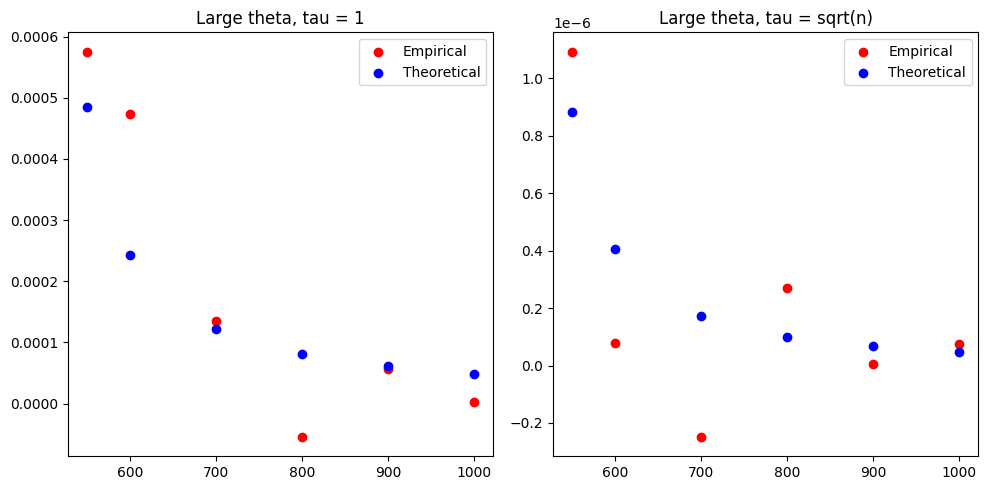

Relative Errors: tensor(2.8855) tensor(7.2438) tensor(24.0022)


In [ ]:
def lem10_1_test():
  Ns = [550,600,700,800,900,1000]
  beta_star = torch.randn(d,1)
  beta_star = beta_star / beta_star.norm()

  u = torch.randn(d,1)
  u = u / u.norm()

  emp_error, theory_error = test_betaTu(lem10_1_emp, lem10_1_theory, Ns=Ns, beta_star = beta_star, u = u, T = 50)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('Large theta, tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('Large theta, tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem10_1_test()

  0%|          | 0/6 [00:00<?, ?it/s]

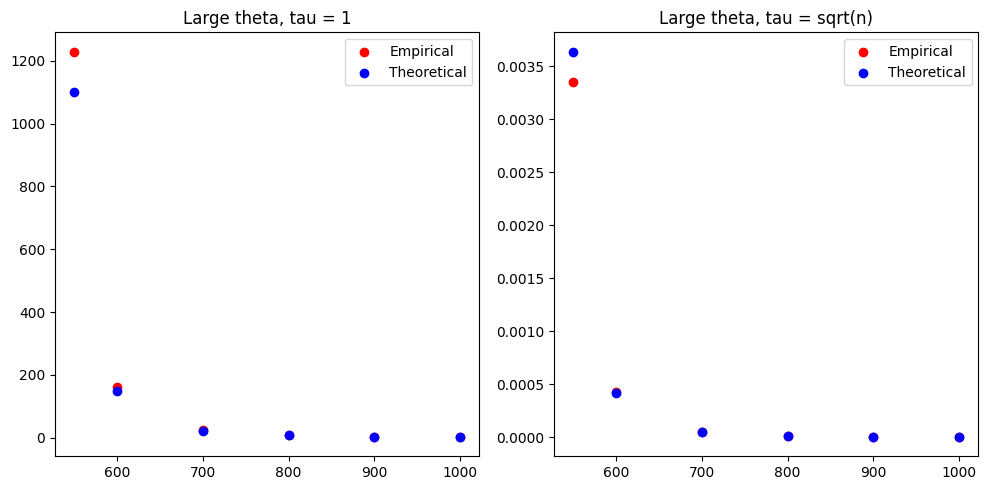

Relative Errors: tensor(0.0354) tensor(0.0349) tensor(0.1054)


In [ ]:
def lem10_2_emp(n, d, tau, T=50):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n, d, tau, tau)
    avg += vars['k'].T @ vars['Ap'] @ vars['Ap'].T @ vars['k']
  return avg / T

def lem10_2_theory(n, d, tau):
  c = d / n
  return c**2 / (tau**4 * (1-c)**3)

def lem10_2_test():
  Ns = [550,600,700,800,900,1000]
  emp_error, theory_error = test(lem10_2_emp, lem10_2_theory, Ns=Ns)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('Large theta, tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('Large theta, tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem10_2_test()

  0%|          | 0/5 [00:00<?, ?it/s]

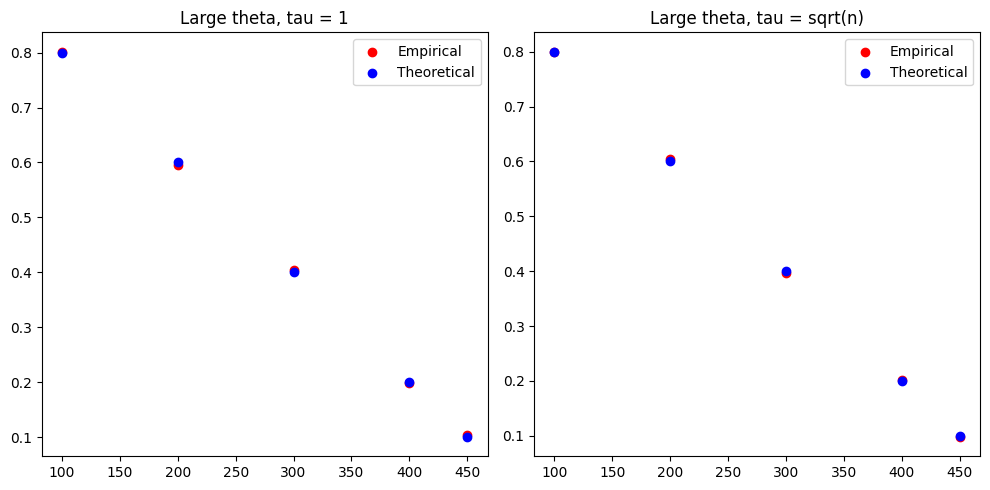

Relative Errors: tensor(0.0111) tensor(0.0111) tensor(0.0378)


In [ ]:
def lem10_3_emp(n, d, tau, beta_star, u, T=50):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n, d, tau, tau, beta_star = beta_star, u = u)
    avg += vars['beta_star'].T @ vars['s'] @  vars['u'].T @ vars['beta_star']
  return avg / T

def lem10_3_theory(n, d, tau, beta_star, u):
    c = d / n
    return ((c-1)/c) * (beta_star.T @ u)**2

def lem10_3_test():
  Ns = [100,200,300,400,450]
  beta_star = torch.randn(d,1)
  beta_star = beta_star / beta_star.norm()

  u = beta_star
  emp_error, theory_error = test_betaTu(lem10_3_emp, lem10_3_theory, Ns=Ns, beta_star = beta_star, u = u)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('Large theta, tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('Large theta, tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem10_3_test()

  0%|          | 0/5 [00:00<?, ?it/s]

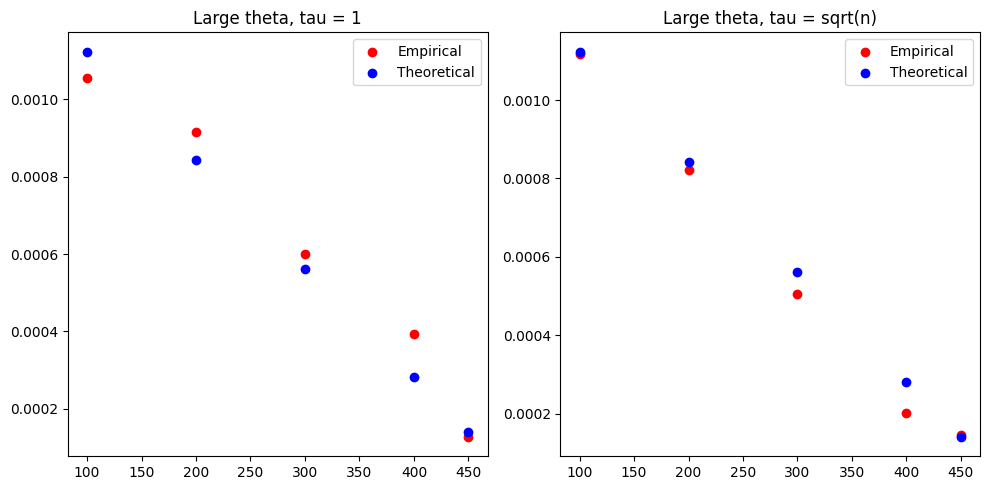

Relative Errors: tensor(0.1172) tensor(0.1224) tensor(0.3861)


In [ ]:
def lem10_3_test():
  Ns = [100,200,300,400,450]
  beta_star = torch.randn(d,1)
  beta_star = beta_star / beta_star.norm()

  u = torch.randn(d,1)
  u = u / u.norm()

  emp_error, theory_error = test_betaTu(lem10_3_emp, lem10_3_theory, Ns=Ns, beta_star = beta_star, u = u, T = 150)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('Large theta, tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('Large theta, tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem10_3_test()

  0%|          | 0/5 [00:00<?, ?it/s]

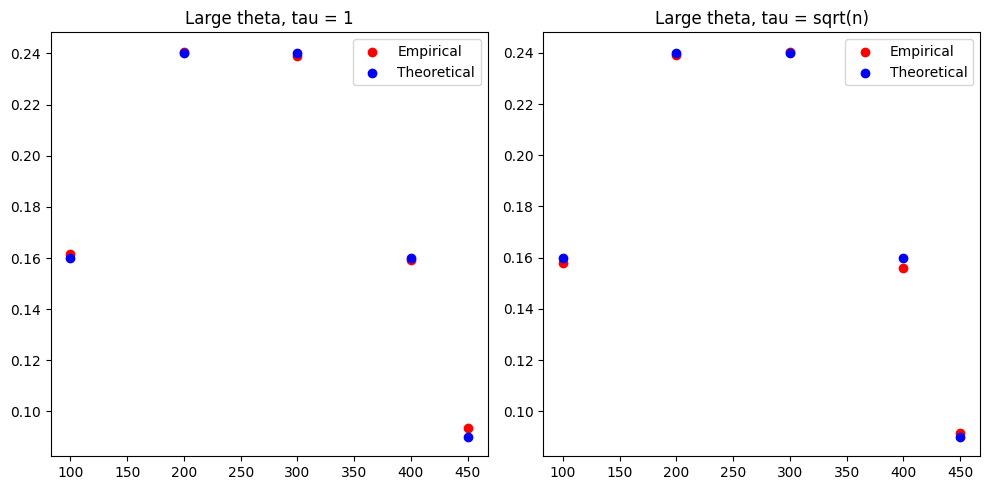

Relative Errors: tensor(0.0122) tensor(0.0115) tensor(0.0371)


In [ ]:
def lem10_4_emp(n, d, tau, beta_star, u, T=50):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n, d, tau, tau, beta_star = beta_star, u = u)
    avg += (vars['beta_star'].T @ vars['u']) * vars['beta_star'].T @ vars['A'] @ vars['Ap'] @  vars['u'] - (vars['beta_star'].T @ vars['A'] @ vars['Ap'] @  vars['u'] )**2
  return avg / T

def lem10_4_theory(n, d, tau, beta_star, u):
    c = d / n
    return (beta_star.T @ u)**2 * (c-1)/(c**2)

def lem10_4_test():
  Ns = [100,200,300,400,450]
  beta_star = torch.randn(d,1)
  beta_star = beta_star / beta_star.norm()

  u = beta_star

  emp_error, theory_error = test_betaTu(lem10_4_emp, lem10_4_theory, Ns=Ns, beta_star = beta_star, u = u)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('Large theta, tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('Large theta, tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem10_4_test()

  0%|          | 0/5 [00:00<?, ?it/s]

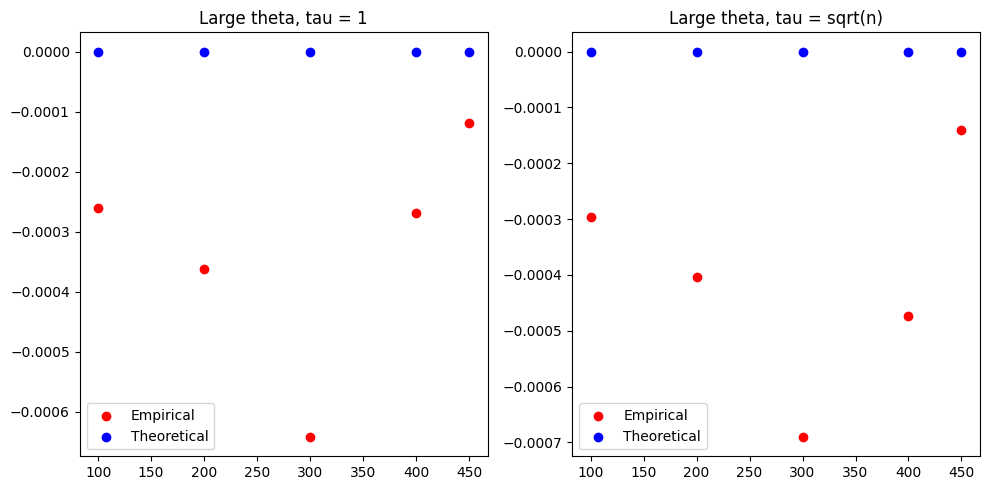

Relative Errors: tensor(-1.) tensor(0.) tensor(-1.)


In [ ]:
def lem10_4_test():
  Ns = [100,200,300,400,450]
  beta_star = torch.randn(d,1)
  beta_star = beta_star / beta_star.norm()

  u = generate_angle_vector(beta_star.flatten(), 90).view(-1,1)
  u = u / u.norm()

  emp_error, theory_error = test_betaTu(lem10_4_emp, lem10_4_theory, Ns=Ns, beta_star = beta_star, u = u, T = 50)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('Large theta, tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('Large theta, tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem10_4_test()

In [ ]:
def lem10_5_emp(n, d, tau, beta_star, u, T=500):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n, d, tau, tau, beta_star = beta_star)
    avg += vars['beta_star'].T @ vars['h'].T @  vars['h'] @ vars['beta_star']
  return avg / T

def lem10_5_theory(n, d, tau, beta_star, u):
    c = d / n
    return (beta_star.square().sum()/d) * (c/(tau**2 *(c-1)))

def lem10_5_test():
  Ns = [100,200,300,400,450]
  emp_error, theory_error = test_betaTu(lem10_5_emp, lem10_5_theory, Ns=Ns, T = 500)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('Large theta, tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('Large theta, tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem10_5_test()

  0%|          | 0/5 [00:00<?, ?it/s]

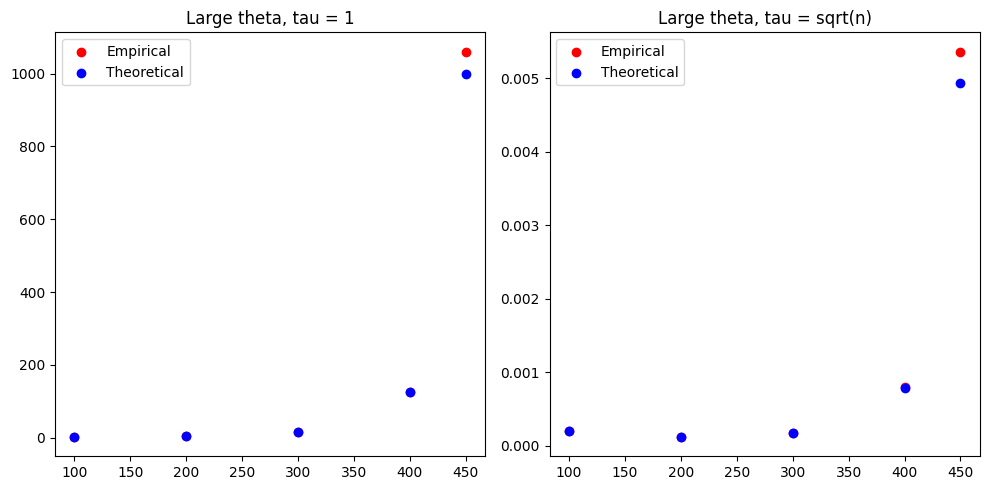

Relative Errors: tensor(0.0346) tensor(0.0266) tensor(0.0790)


In [ ]:
def lem10_6_emp(n, d, tau, T=50):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n, d, tau, tau)
    avg += (vars['Ap'] @ vars['h'].T).square().sum()
  return avg / T

def lem10_6_theory(n, d, tau):
    c = d / n
    return (c**3/(tau**4 * (c-1)**3))

def lem10_6_test():
  Ns = [100,200,300,400,450]
  emp_error, theory_error = test(lem10_6_emp, lem10_6_theory, Ns=Ns)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('Large theta, tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('Large theta, tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem10_6_test()

## Lemma 11

  0%|          | 0/11 [00:00<?, ?it/s]

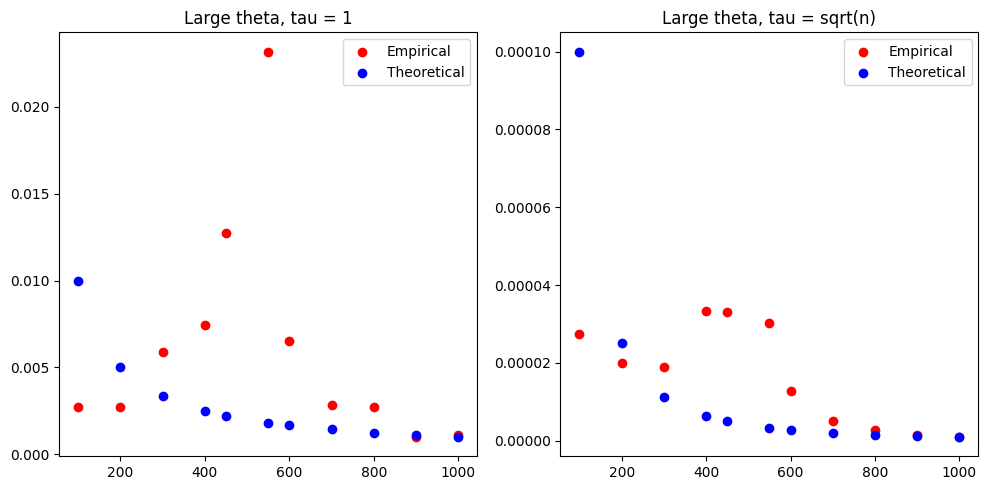

In [ ]:
def lem11_1_emp(n,d,tau, beta_star = None, u = None, T = 50):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n,d,tau,tau, beta_star = beta_star, u = u)
    avg += (vars['beta_star'].T @ vars['u'] @ vars['h'] @ vars['beta_star'])**2
  return avg / T

def lem11_1_theory(n,d,tau, beta_star = None, u = None):
  return 1/(tau**2 * n)

def lem11_1_test():
  Ns = [100,200,300,400,450,550,600,700,800,900,1000]
  beta_star = torch.randn(d,1)
  beta_star = beta_star / beta_star.norm()

  u = generate_angle_vector(beta_star.flatten(), 0).view(-1,1)
  u = u / u.norm()

  emp_error, theory_error = test_betaTu(lem11_1_emp, lem11_1_theory, Ns=Ns, beta_star = beta_star, u = u, T = 50)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('Large theta, tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('Large theta, tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  # rel_errors = (emp_error-theory_error).abs()/(emp_error)

  # print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem11_1_test()

  0%|          | 0/11 [00:00<?, ?it/s]

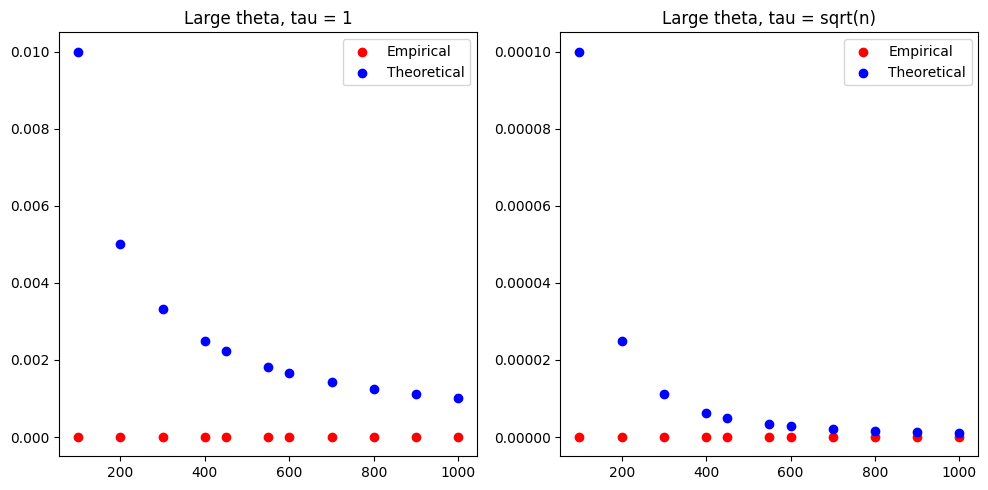

In [ ]:
def lem11_1_test():
  Ns = [100,200,300,400,450,550,600,700,800,900,1000]
  beta_star = torch.randn(d,1)
  beta_star = beta_star / beta_star.norm()

  u = generate_angle_vector(beta_star.flatten(), 90).view(-1,1)
  u = u / u.norm()

  emp_error, theory_error = test_betaTu(lem11_1_emp, lem11_1_theory, Ns=Ns, beta_star = beta_star, u = u, T = 50)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('Large theta, tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('Large theta, tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  # rel_errors = (emp_error-theory_error).abs()/(emp_error)

  # print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem11_1_test()

  0%|          | 0/5 [00:00<?, ?it/s]

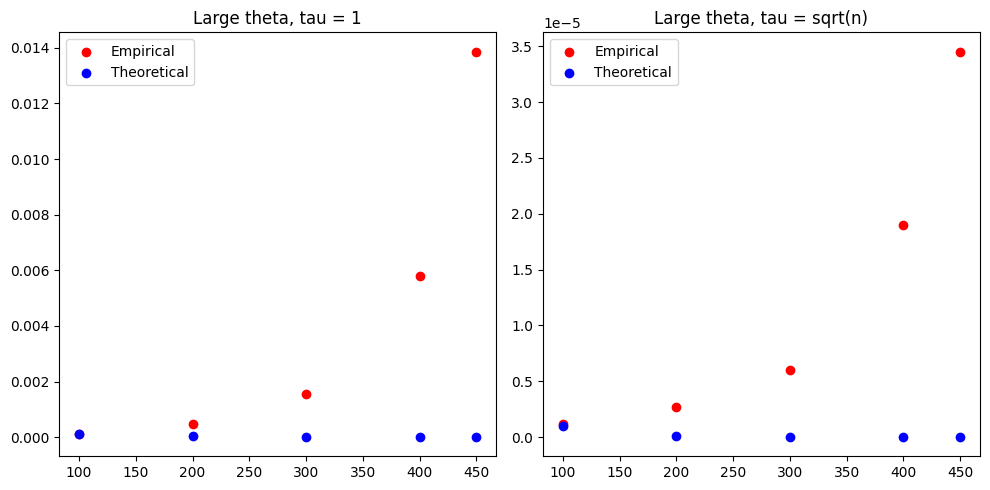

Relative Errors: tensor(0.8049) tensor(0.3830) tensor(0.9997)


In [ ]:
def lem11_2_emp(n,d,tau, beta_star = None, u = None, T = 50):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n,d,tau,tau, beta_star = beta_star, u = u)
    avg += (vars['beta_star'].T @ vars['A'] @ vars['Ap'] @ vars['u'] @ vars['h'] @ vars['beta_star'])**2
  return avg / T

def lem11_2_theory(n,d,tau, beta_star = None, u = None):
  return 1/(tau**2 * n**2)

def lem11_2_test():
  Ns = [100,200,300,400,450]
  beta_star = torch.randn(d,1)
  beta_star = beta_star / beta_star.norm()

  u = generate_angle_vector(beta_star.flatten(), 0).view(-1,1)
  u = u / u.norm()

  emp_error, theory_error = test_betaTu(lem11_2_emp, lem11_2_theory, Ns=Ns, beta_star = beta_star, u = u, T = 50)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('Large theta, tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('Large theta, tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem11_2_test()

  0%|          | 0/5 [00:00<?, ?it/s]

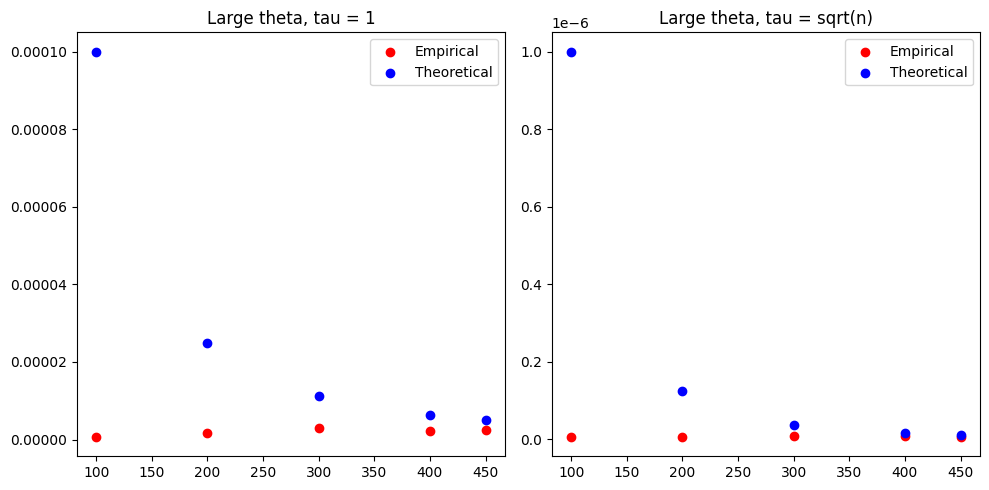

Relative Errors: tensor(35.0382) tensor(62.3551) tensor(153.0588)


In [ ]:
def lem11_2_test():
  Ns = [100,200,300,400,450]
  beta_star = torch.randn(d,1)
  beta_star = beta_star / beta_star.norm()

  u = generate_angle_vector(beta_star.flatten(), 90).view(-1,1)
  u = u / u.norm()

  emp_error, theory_error = test_betaTu(lem11_2_emp, lem11_2_theory, Ns=Ns, beta_star = beta_star, u = u, T = 50)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('Large theta, tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('Large theta, tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem11_2_test()

  0%|          | 0/5 [00:00<?, ?it/s]

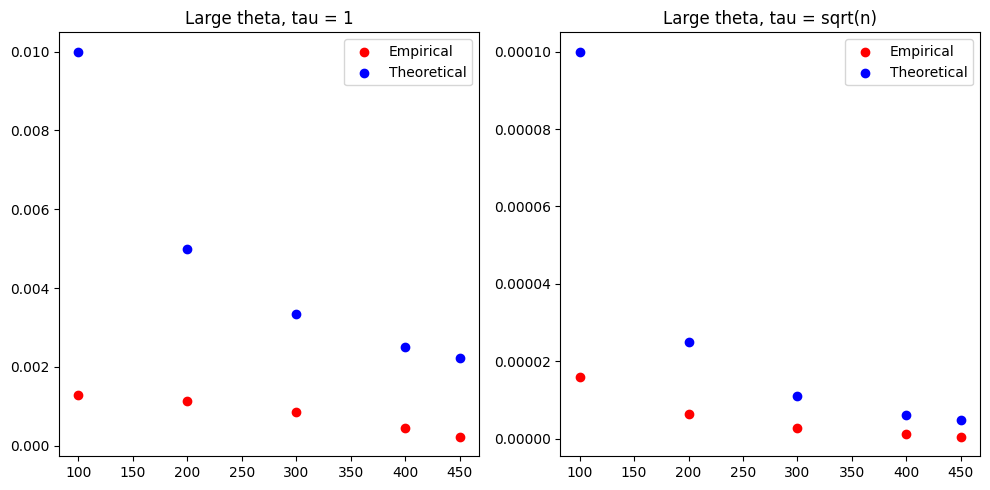

Relative Errors: tensor(5.1400) tensor(2.5913) tensor(9.9350)


In [ ]:
def lem11_3_emp(n,d,tau, beta_star = None, u = None, T = 50):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n,d,tau,tau, beta_star = beta_star, u = u)
    avg += (vars['beta_star'].T @ vars['s'] @ vars['h'] @ vars['beta_star'])**2
  return avg / T

def lem11_3_theory(n,d,tau, beta_star = None, u = None):
  return 1/(tau**2 * n)

def lem11_3_test():
  Ns = [100,200,300,400,450]
  beta_star = torch.randn(d,1)
  beta_star = beta_star / beta_star.norm()

  u = generate_angle_vector(beta_star.flatten(), 0).view(-1,1)
  u = u / u.norm()

  emp_error, theory_error = test_betaTu(lem11_3_emp, lem11_3_theory, Ns=Ns, beta_star = beta_star, u = u, T = 50)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('Large theta, tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('Large theta, tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem11_3_test()

  0%|          | 0/5 [00:00<?, ?it/s]

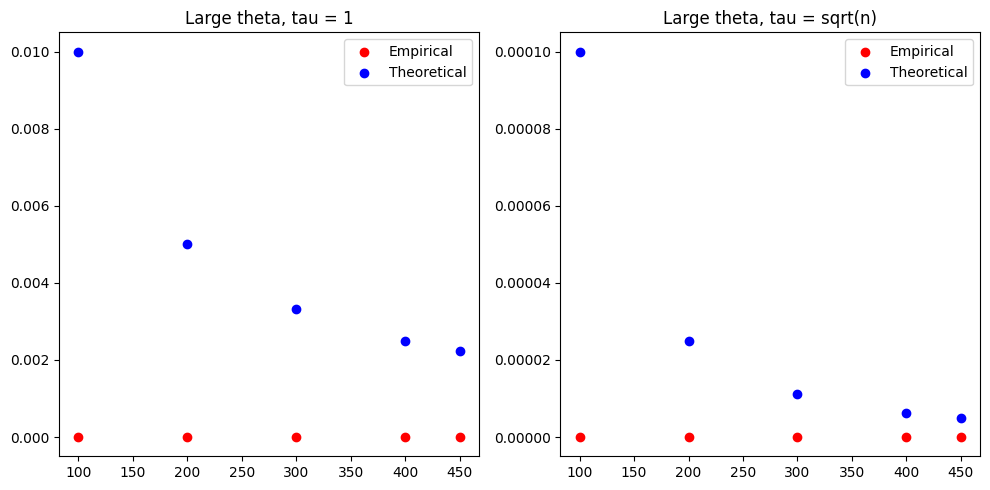

Relative Errors: tensor(4105.8037) tensor(5545.2012) tensor(16649.7500)


In [ ]:
def lem11_3_test():
  Ns = [100,200,300,400,450]
  beta_star = torch.randn(d,1)
  beta_star = beta_star / beta_star.norm()

  u = generate_angle_vector(beta_star.flatten(), 90).view(-1,1)
  u = u / u.norm()

  emp_error, theory_error = test_betaTu(lem11_3_emp, lem11_3_theory, Ns=Ns, beta_star = beta_star, u = u, T = 50)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('Large theta, tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('Large theta, tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem11_3_test()

  0%|          | 0/11 [00:00<?, ?it/s]

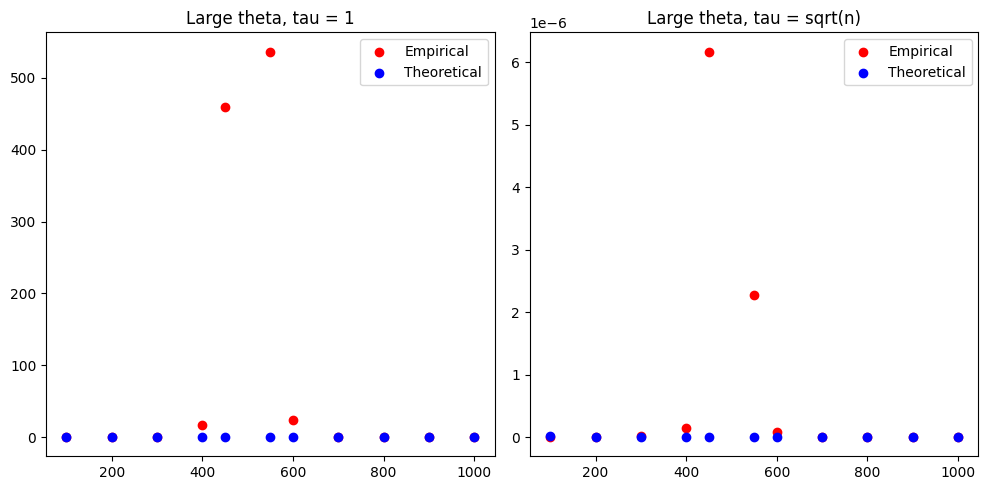

In [ ]:
def lem11_4_emp(n,d,tau, beta_star = None, u = None, T = 50):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n,d,tau,tau, beta_star = beta_star, u = u)
    avg += (vars['k'].T @ vars['Ap'] @ vars['h'].T)**2
  return avg / T

def lem11_4_theory(n,d,tau, beta_star = None, u = None):
  return 1/(tau**6 * n)

def lem11_4_test():
  Ns = [100,200,300,400,450,550,600,700,800,900,1000]
  beta_star = torch.randn(d,1)
  beta_star = beta_star / beta_star.norm()

  u = generate_angle_vector(beta_star.flatten(), 0).view(-1,1)
  u = u / u.norm()

  emp_error, theory_error = test_betaTu(lem11_4_emp, lem11_4_theory, Ns=Ns, beta_star = beta_star, u = u, T = 50)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('Large theta, tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('Large theta, tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  # rel_errors = (emp_error-theory_error).abs()/(emp_error)

  # print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem11_4_test()

  0%|          | 0/11 [00:00<?, ?it/s]

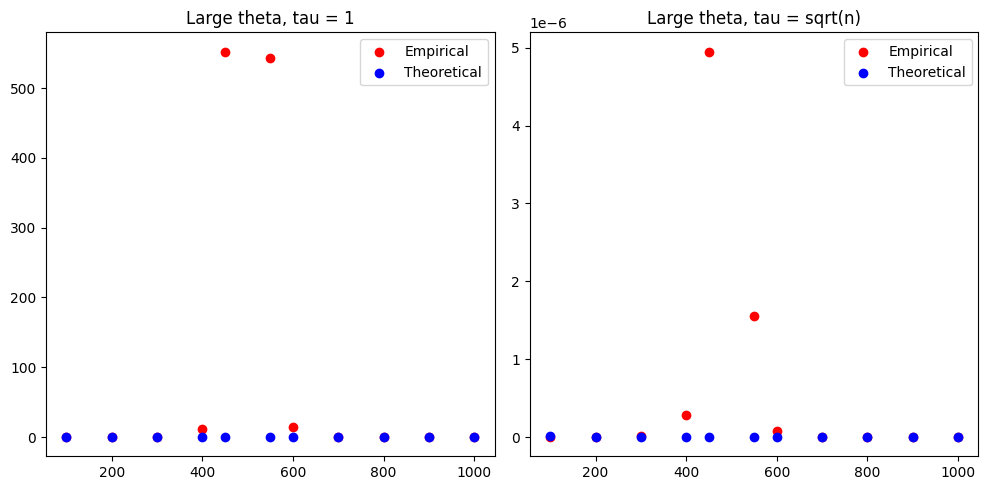

In [ ]:
def lem11_4_test():
  Ns = [100,200,300,400,450,550,600,700,800,900,1000]
  beta_star = torch.randn(d,1)
  beta_star = beta_star / beta_star.norm()

  u = generate_angle_vector(beta_star.flatten(), 90).view(-1,1)
  u = u / u.norm()

  emp_error, theory_error = test_betaTu(lem11_4_emp, lem11_4_theory, Ns=Ns, beta_star = beta_star, u = u, T = 50)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('Large theta, tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('Large theta, tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  # rel_errors = (emp_error-theory_error).abs()/(emp_error)

  # print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem11_4_test()

## Lemma 12

  0%|          | 0/6 [00:00<?, ?it/s]

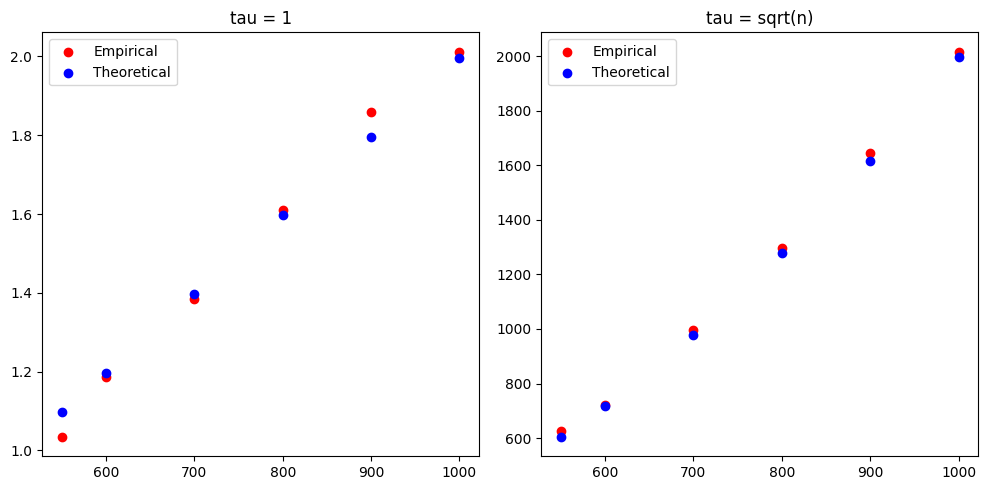

Relative Errors: tensor(0.0191) tensor(0.0168) tensor(0.0616)


In [ ]:
def lem12_1_emp(n, d, tau, T = 50):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n,d,tau,tau)
    avg += vars['theta']**2 / vars['gamma_1']
  return avg / T

def lem12_1_theory(n,d,tau):
  c = d/n
  theta = np.sqrt(n) * tau
  return theta**2 * tau**2 / (theta**2 * c + tau**2)

def lem12_1_test():
  Ns = [550,600,700,800,900,1000]
  emp_error, theory_error = test(lem12_1_emp, lem12_1_theory, Ns=Ns)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem12_1_test()

  0%|          | 0/5 [00:00<?, ?it/s]

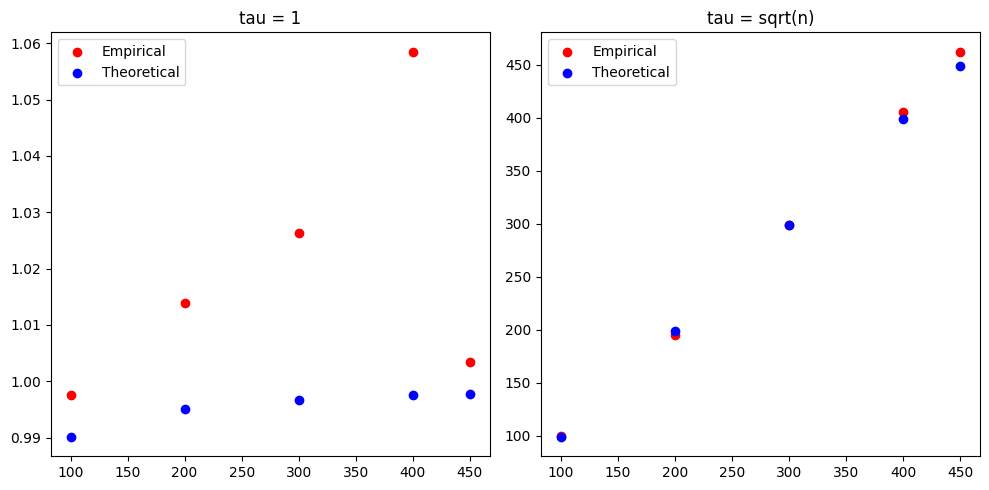

Relative Errors: tensor(0.0190) tensor(0.0166) tensor(0.0577)


In [ ]:
def lem12_2_emp(n, d, tau, T = 50):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n,d,tau,tau)
    avg += vars['theta']**2 / vars['gamma_2']
  return avg / T

def lem12_2_theory(n,d,tau):
  c = d/n
  theta = np.sqrt(n) * tau
  return theta**2 * tau**2 / (theta**2 + tau**2)

def lem12_2_test():
  Ns = [100,200,300,400,450]
  emp_error, theory_error = test(lem12_2_emp, lem12_2_theory, Ns=Ns)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem12_2_test()

## Lemma 13

  0%|          | 0/6 [00:00<?, ?it/s]

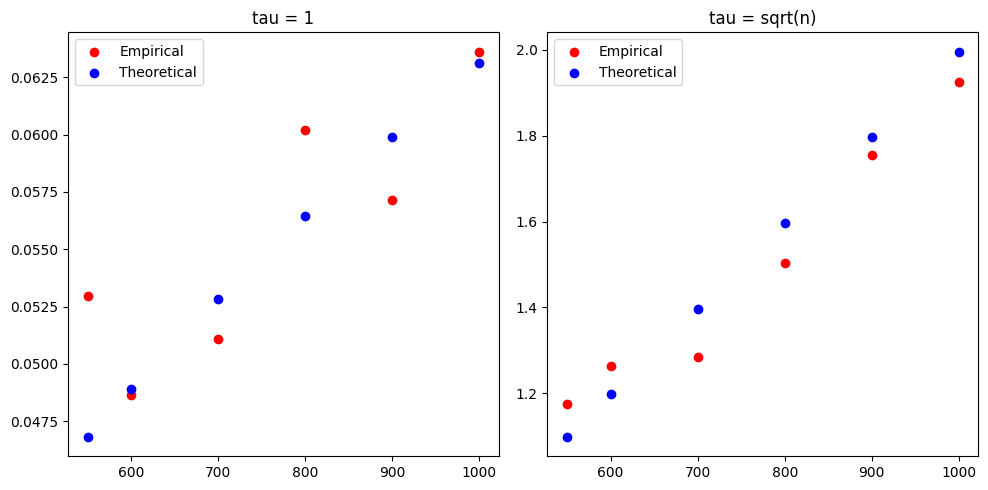

Relative Errors: tensor(0.0499) tensor(0.0320) tensor(0.1161)


In [ ]:
def lem13_1_emp(n, d, tau, T = 500):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n,d,tau,tau)
    avg += vars['theta']* vars['xi'] / vars['gamma_1']
  return avg / T

def lem13_1_theory(n,d,tau):
  c = d/n
  theta = np.sqrt(n) * tau
  return theta * tau**2 / (theta**2 * c + tau**2)

def lem13_1_test():
  Ns = [550,600,700,800,900,1000]
  emp_error, theory_error = test(lem13_1_emp, lem13_1_theory, Ns=Ns)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem13_1_test()

  0%|          | 0/5 [00:00<?, ?it/s]

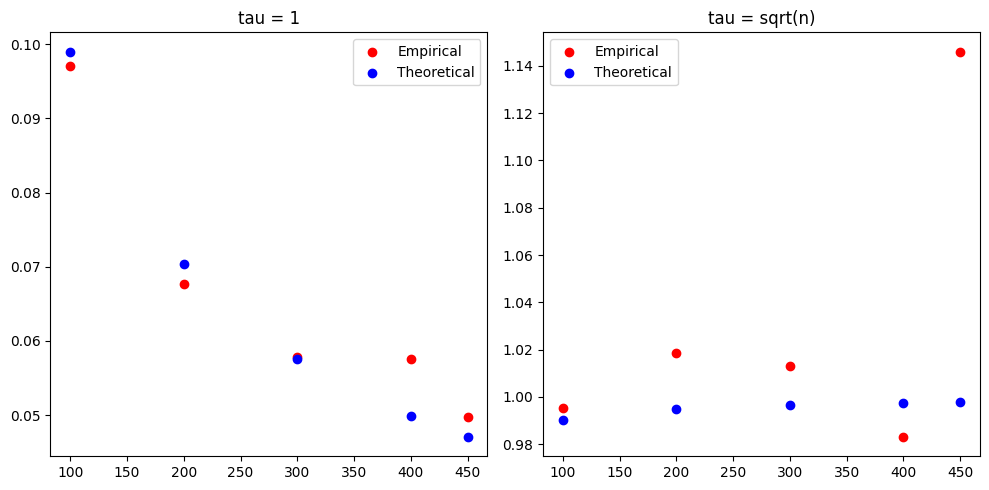

Relative Errors: tensor(0.0441) tensor(0.0484) tensor(0.1330)


In [ ]:
def lem13_2_emp(n, d, tau, T = 500):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n,d,tau,tau)
    avg += vars['theta']* vars['xi'] / vars['gamma_2']
  return avg / T

def lem13_2_theory(n,d,tau):
  c = d/n
  theta = np.sqrt(n) * tau
  return theta * tau**2 / (theta**2 + tau**2)

def lem13_2_test():
  Ns = [100,200,300,400,450]
  emp_error, theory_error = test(lem13_2_emp, lem13_2_theory, Ns=Ns)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem13_2_test()

## Lemma 14

  0%|          | 0/6 [00:00<?, ?it/s]

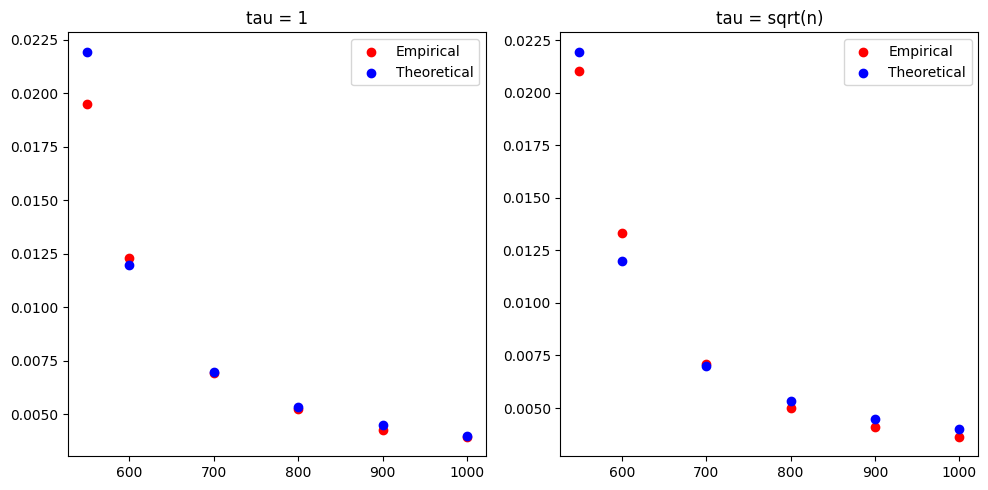

Relative Errors: tensor(0.0548) tensor(0.0419) tensor(0.1263)


In [ ]:
def lem14_1_emp(n, d, tau, T = 500):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n,d,tau,tau)
    avg += vars['xi']**2 / vars['gamma_1']
  return avg / T

def lem14_1_theory(n,d,tau):
  c = d/n
  theta = np.sqrt(n) * tau
  return (tau**2 / (theta**2 * c + tau**2)) * (1 + ((theta**2)/(n*tau**2)) * (c/np.abs(1-c)))

def lem14_1_test():
  Ns = [550,600,700,800,900,1000]
  emp_error, theory_error = test(lem14_1_emp, lem14_1_theory, Ns=Ns)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem14_1_test()

  0%|          | 0/5 [00:00<?, ?it/s]

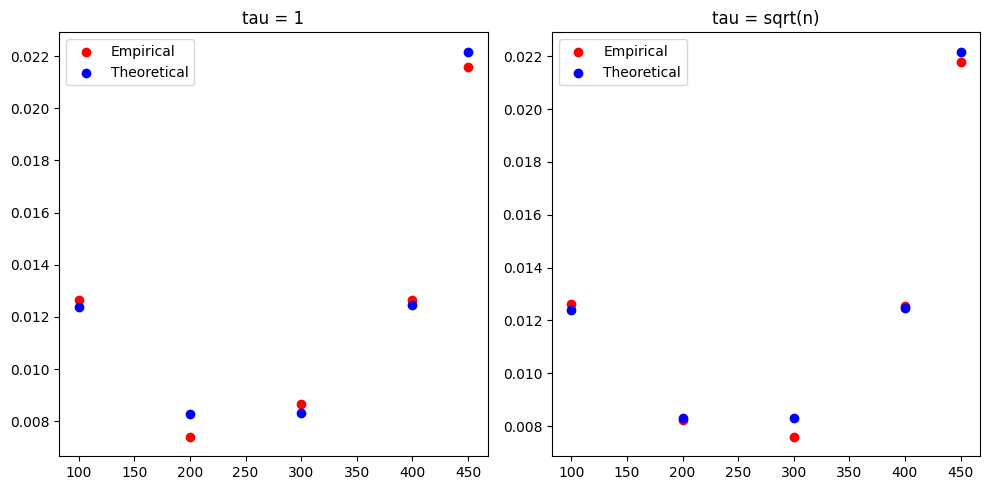

Relative Errors: tensor(0.0375) tensor(0.0391) tensor(0.1214)


In [ ]:
def lem14_2_emp(n, d, tau, T = 500):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n,d,tau,tau)
    avg += vars['xi']**2 / vars['gamma_2']
  return avg / T

def lem14_2_theory(n,d,tau):
  c = d/n
  theta = np.sqrt(n) * tau
  return tau**2 / (theta**2 + tau**2) * (1 + ((theta**2)/(n*tau**2)) * (1/np.abs(1-c)))

def lem14_2_test():
  Ns = [100,200,300,400,450]
  emp_error, theory_error = test(lem14_2_emp, lem14_2_theory, Ns=Ns)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem14_2_test()

## Lemma 15

  0%|          | 0/6 [00:00<?, ?it/s]

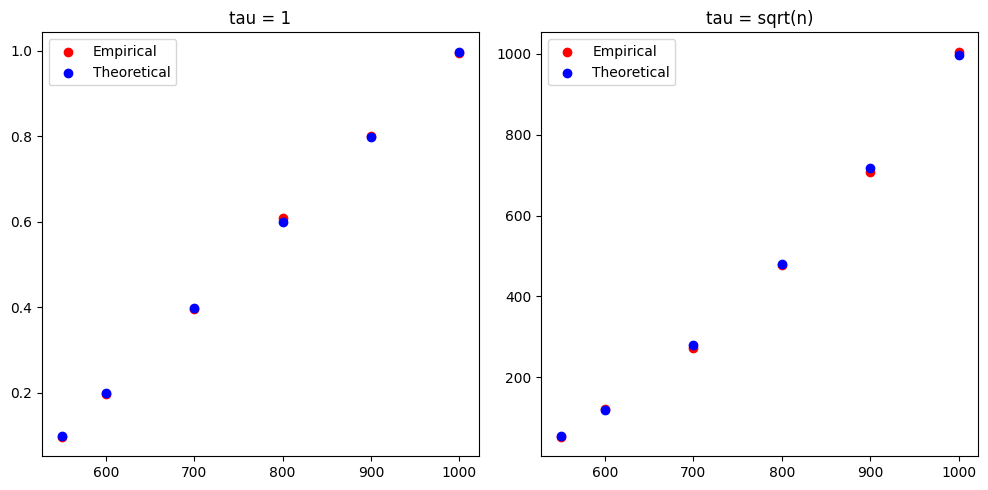

Relative Errors: tensor(0.0157) tensor(0.0161) tensor(0.0606)


In [ ]:
def lem15_1_emp(n, d, tau, T = 50):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n,d,tau,tau)
    avg += vars['theta']**2 * vars['tnorm_sq'] / vars['gamma_1']
  return avg / T

def lem15_1_theory(n,d,tau):
  c = d/n
  theta = np.sqrt(n) * tau
  return (tau**2 * theta**2 / (theta**2 * c + tau**2)) * (1-c)

def lem15_1_test():
  Ns = [550,600,700,800,900,1000]
  emp_error, theory_error = test(lem15_1_emp, lem15_1_theory, Ns=Ns)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem15_1_test()

  0%|          | 0/6 [00:00<?, ?it/s]

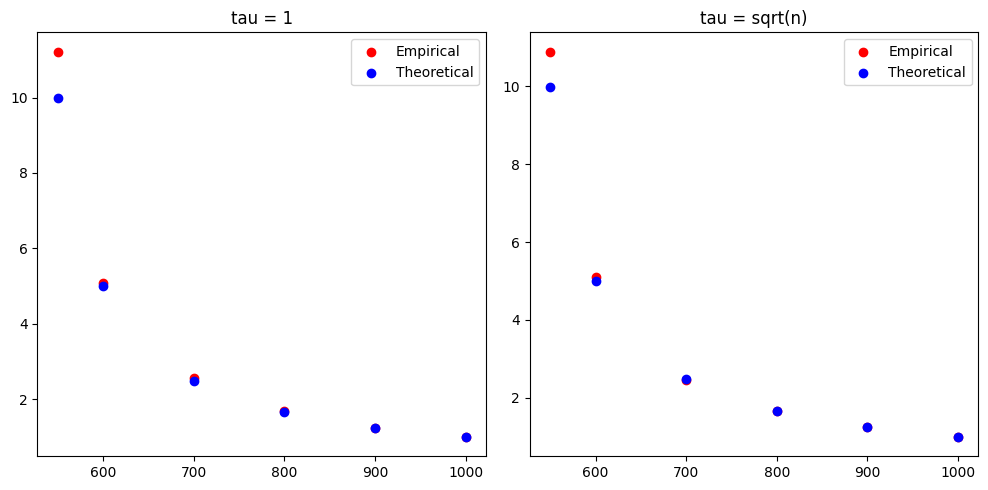

Relative Errors: tensor(0.0263) tensor(0.0343) tensor(0.1104)


In [ ]:
def lem15_2_emp(n, d, tau, T = 50):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n,d,tau,tau)
    avg += vars['theta']**2 * vars['hnorm_sq'] / vars['gamma_1']
  return avg / T

def lem15_2_theory(n,d,tau):
  c = d/n
  theta = np.sqrt(n) * tau
  return (theta**2 / (theta**2 * c + tau**2)) * (c**2 / (1-c))

def lem15_2_test():
  Ns = [550,600,700,800,900,1000]
  emp_error, theory_error = test(lem15_2_emp, lem15_2_theory, Ns=Ns)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem15_2_test()

  0%|          | 0/5 [00:00<?, ?it/s]

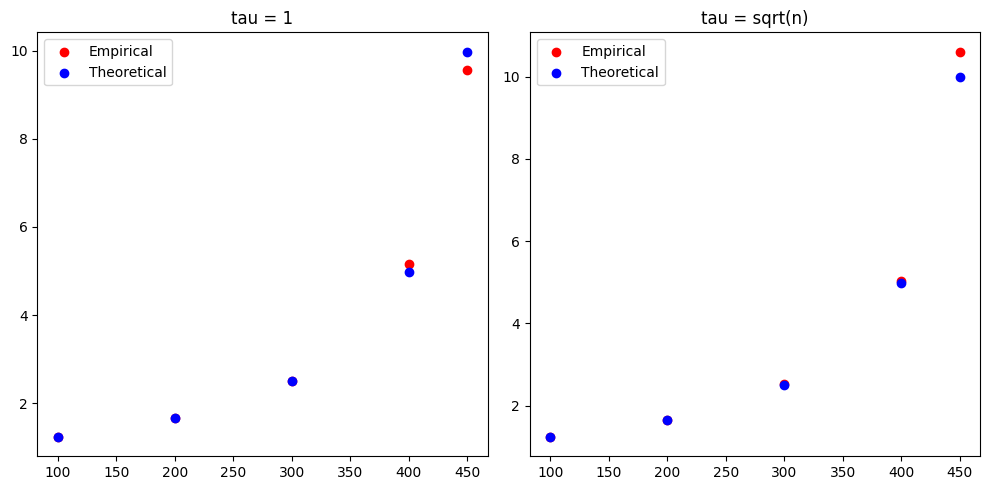

Relative Errors: tensor(0.0179) tensor(0.0206) tensor(0.0593)


In [ ]:
def lem15_3_emp(n, d, tau, T = 50):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n,d,tau,tau)
    avg += vars['theta']**2 * vars['hnorm_sq'] / vars['gamma_2']
  return avg / T

def lem15_3_theory(n,d,tau):
  c = d/n
  theta = np.sqrt(n) * tau
  return (theta**2 / (theta**2 + tau**2)) * (c/(c-1))

def lem15_3_test():
  Ns = [100,200,300,400,450]
  emp_error, theory_error = test(lem15_3_emp, lem15_3_theory, Ns=Ns)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem15_3_test()

## Lemma 16

  0%|          | 0/6 [00:00<?, ?it/s]

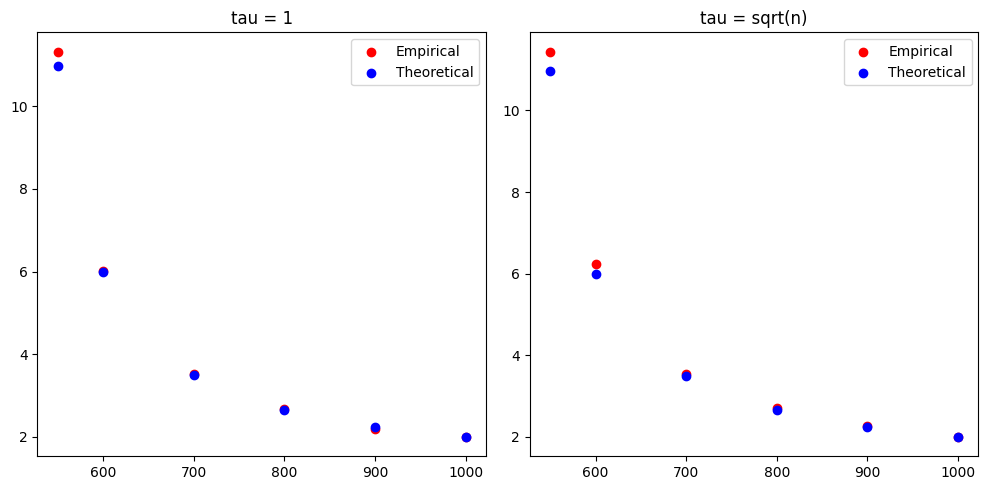

Relative Errors: tensor(0.0168) tensor(0.0139) tensor(0.0406)


In [ ]:
def lem16_1_emp(n, d, tau, T = 50):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n,d,tau,tau)
    avg += vars['theta']**2 * vars['knorm_sq'] / vars['gamma_1']
  return avg / T

def lem16_1_theory(n,d,tau):
  c = d/n
  theta = np.sqrt(n) * tau
  return (theta**2 / (theta**2 * c + tau**2)) * (c/(1-c))

def lem16_1_test():
  Ns = [550,600,700,800,900,1000]
  emp_error, theory_error = test(lem16_1_emp, lem16_1_theory, Ns=Ns)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem16_1_test()

In [ ]:
def lem16_2_emp(n, d, tau, T = 50):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n,d,tau,tau)
    avg += vars['theta']**2 * vars['snorm_sq'] / vars['gamma_2']
  return avg / T

def lem16_2_theory(n,d,tau):
  c = d/n
  theta = np.sqrt(n) * tau
  return (tau**2 * theta**2 / (theta**2  + tau**2)) * (1-1/c)

def lem16_2_test():
  Ns = [100,200,300,400,450]
  emp_error, theory_error = test(lem16_2_emp, lem16_2_theory, Ns=Ns)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem16_2_test()

  0%|          | 0/5 [00:00<?, ?it/s]

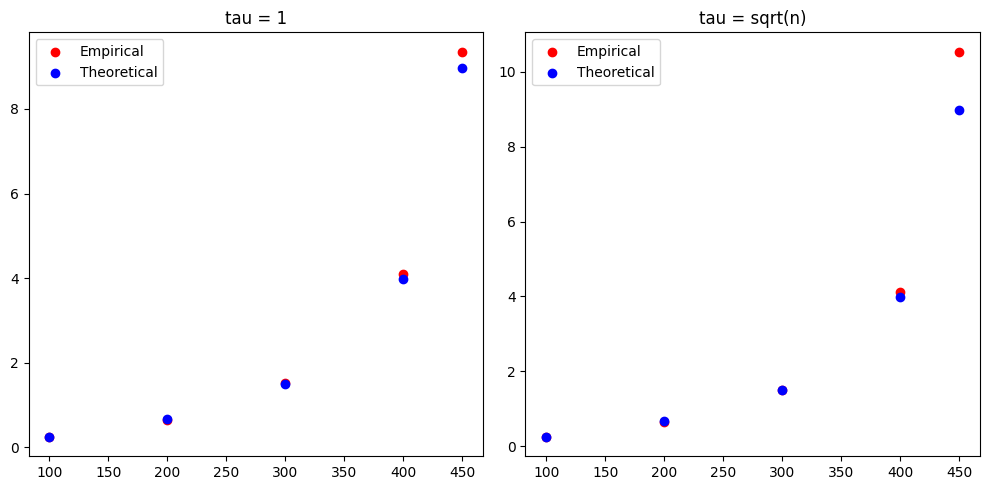

Relative Errors: tensor(0.0326) tensor(0.0418) tensor(0.1483)


In [ ]:
def lem16_3_emp(n, d, tau, T = 50):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n,d,tau,tau)
    avg += vars['theta']**2 * vars['knorm_sq'] / vars['gamma_2']
  return avg / T

def lem16_3_theory(n,d,tau):
  c = d/n
  theta = np.sqrt(n) * tau
  return (theta**2 / (theta**2  + tau**2)) * 1/(c-1)

def lem16_3_test():
  Ns = [100,200,300,400,450]
  emp_error, theory_error = test(lem16_3_emp, lem16_3_theory, Ns=Ns)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem16_3_test()

## Lemma 18

  0%|          | 0/11 [00:00<?, ?it/s]

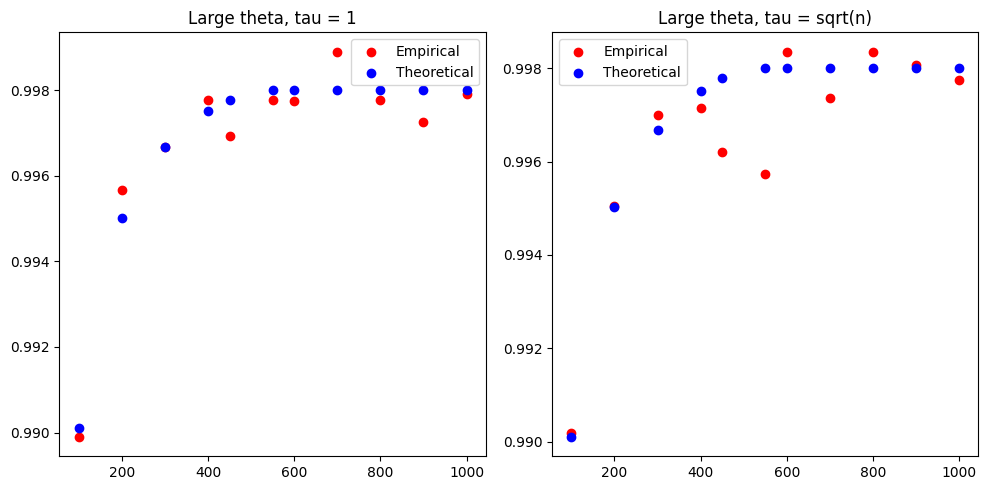

Relative Errors: tensor(0.0005) tensor(0.0005) tensor(0.0023)


In [ ]:
def lem18_emp(n,d,tau, beta_star = None, u = None, T = 50):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n,d,tau,tau, beta_star = beta_star, u = u)
    avg += vars['beta_star'].T @ vars['Xp'].T @ vars['Z'].T @ vars['beta_star']
  return avg / T

def lem18_theory(n,d,tau, beta_star = None, u = None):
  c = d/n
  coeff = (beta_star.T @ u)**2
  theta = np.sqrt(n)*tau
  if c < 1:
    return ((theta**2 * c)/(theta**2 * c + tau**2 )) * coeff
  else:
    return ((theta**2 )/(theta**2 + tau**2 )) * coeff

def lem18_test():
  Ns = [100,200,300,400,450,550,600,700,800,900,1000]
  beta_star = torch.randn(d,1)
  beta_star = beta_star / beta_star.norm()

  u = generate_angle_vector(beta_star.flatten(), 0).view(-1,1)
  u = u / u.norm()

  emp_error, theory_error = test_betaTu(lem18_emp, lem18_theory, Ns=Ns, beta_star = beta_star, u = u, T = 50)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('Large theta, tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('Large theta, tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem18_test()

  0%|          | 0/11 [00:00<?, ?it/s]

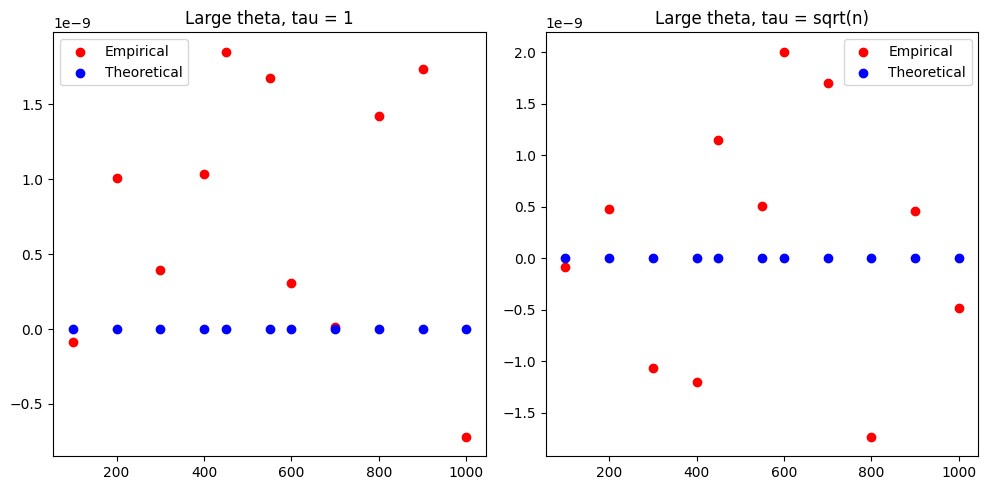

Relative Errors: tensor(0.3636) tensor(0.9535) tensor(1.0000)


In [ ]:
def lem18_test():
  Ns = [100,200,300,400,450,550,600,700,800,900,1000]
  beta_star = torch.randn(d,1)
  beta_star = beta_star / beta_star.norm()

  u = generate_angle_vector(beta_star.flatten(), 90).view(-1,1)
  u = u / u.norm()

  emp_error, theory_error = test_betaTu(lem18_emp, lem18_theory, Ns=Ns, beta_star = beta_star, u = u, T = 50)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('Large theta, tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('Large theta, tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem18_test()

## Lemma 19

  0%|          | 0/11 [00:00<?, ?it/s]

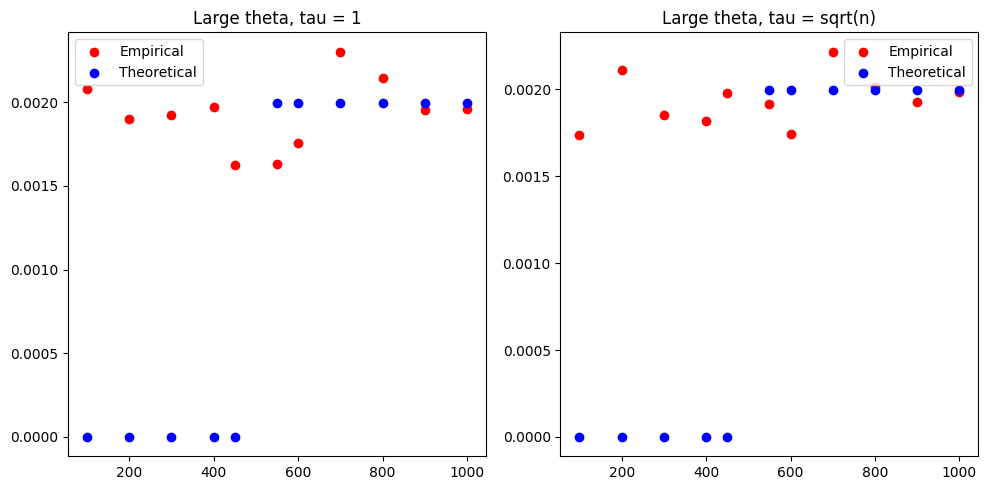

Relative Errors: tensor(0.4972) tensor(0.4724) tensor(1.0001)


In [ ]:
def lem19_emp(n,d,tau, beta_star = None, u = None, T = 500):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n,d,tau,tau, beta_star = beta_star, u = u)
    avg += vars['beta_star'].T @ vars['Xp'].T @ vars['A'].T @ vars['beta_star']
  return avg / T

def lem19_theory(n,d,tau, beta_star = None, u = None):
  c = d/n
  coeff = (beta_star.T @ u)**2
  theta = np.sqrt(n)*tau
  if c < 1:
    return (beta_star).square().sum() - (((theta**2 * c)/(theta**2 * c + tau**2 )) * coeff).item()
  else:
    return (1/c - (1/d) * (theta**2)/(theta**2 + tau**2)) * (beta_star).square().sum() - ((theta**2 )/(theta**2 + tau**2 )) * coeff/c

def lem19_test():
  Ns = [100,200,300,400,450,550,600,700,800,900,1000]
  beta_star = torch.randn(d,1)
  beta_star = beta_star / beta_star.norm()

  u = generate_angle_vector(beta_star.flatten(), 0).view(-1,1)
  u = u / u.norm()

  emp_error, theory_error = test_betaTu(lem19_emp, lem19_theory, Ns=Ns, beta_star = beta_star, u = u, T = 500)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('Large theta, tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('Large theta, tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem19_test()

In [ ]:
def lem19_test():
  Ns = [100,200,300,400,450,550,600,700,800,900,1000]
  beta_star = torch.randn(d,1)
  beta_star = beta_star / beta_star.norm()

  u = generate_angle_vector(beta_star.flatten(), 45).view(-1,1)
  u = u / u.norm()

  emp_error, theory_error = test_betaTu(lem19_emp, lem19_theory, Ns=Ns, beta_star = beta_star, u = u, T = 500)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('Large theta, tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('Large theta, tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem19_test()

  0%|          | 0/11 [00:00<?, ?it/s]

KeyboardInterrupt: 

  0%|          | 0/11 [00:00<?, ?it/s]

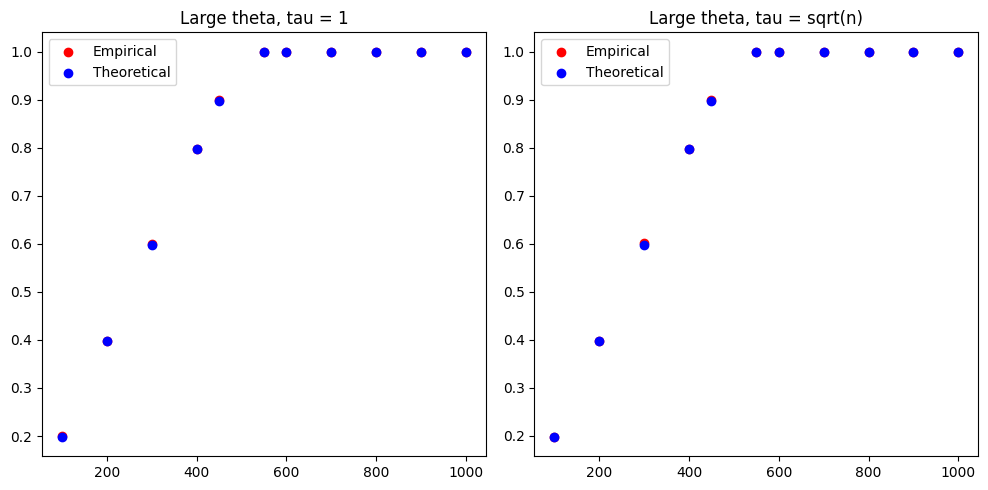

Relative Errors: tensor(0.0012) tensor(0.0020) tensor(0.0076)


In [ ]:
def lem19_test():
  Ns = [100,200,300,400,450,550,600,700,800,900,1000]
  beta_star = torch.randn(d,1)
  beta_star = beta_star / beta_star.norm()

  u = generate_angle_vector(beta_star.flatten(), 90).view(-1,1)
  u = u / u.norm()

  emp_error, theory_error = test_betaTu(lem19_emp, lem19_theory, Ns=Ns, beta_star = beta_star, u = u, T = 500)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('Large theta, tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('Large theta, tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem19_test()

## Lemma 20

  0%|          | 0/6 [00:00<?, ?it/s]

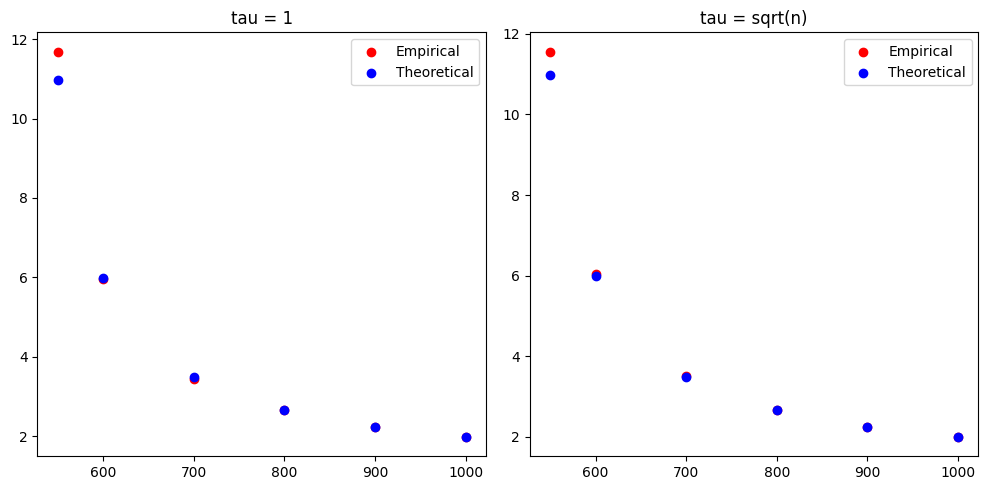

Relative Errors: tensor(0.0138) tensor(0.0199) tensor(0.0604)


In [ ]:
def lem20_1_emp(n,d,tau, T = 50):
  avg = 0
  for _ in range(50):
    vars = gen_variables(n,d,tau,tau)
    avg += (vars['xi']**2/vars['gamma_1']**2) * (vars['p1'].square().sum())
  return avg/T

def lem20_1_theory(n,d,tau):
  c = d/n
  theta = np.sqrt(n) * tau
  return c/(1-c) * theta**2 / (theta**2 * c+ tau**2)

def lem20_1_test():
  Ns = [550,600,700,800,900,1000]
  emp_error, theory_error = test(lem20_1_emp, lem20_1_theory, Ns=Ns)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem20_1_test()

  0%|          | 0/5 [00:00<?, ?it/s]

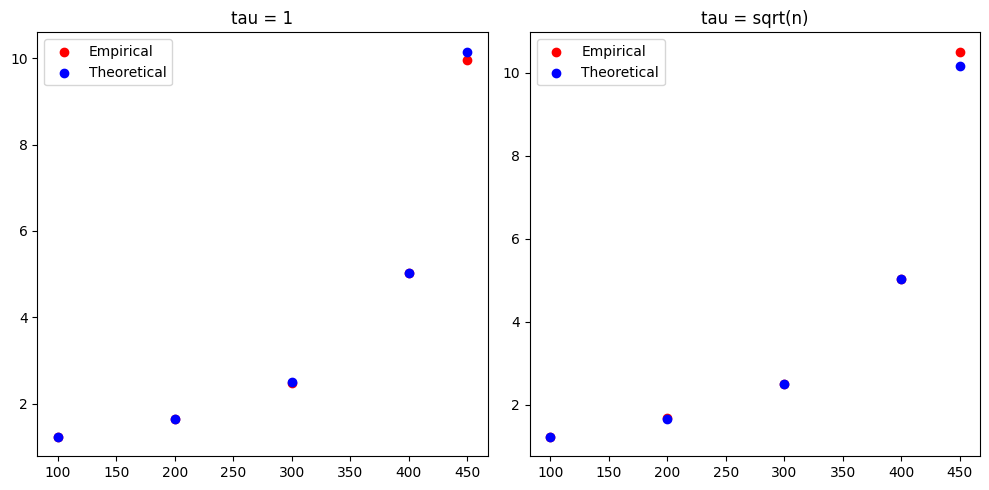

Relative Errors: tensor(0.0096) tensor(0.0111) tensor(0.0340)


In [ ]:
def lem20_2_emp(n,d,tau, T = 50):
  avg = 0
  for _ in range(50):
    vars = gen_variables(n,d,tau,tau)
    avg += (vars['xi']**2/vars['gamma_2']**2) * (vars['p2'].square().sum())
  return avg/T

def lem20_2_theory(n,d,tau):
  c = d/n
  theta = np.sqrt(n) * tau
  # return lem16_2_theory(n,d,tau)**2 * lem10_6_theory(n,d,tau) + lem16_3_theory(n,d,tau) * lem14_2_theory(n,d,tau)
  return (1/((c-1)) * (theta**4 * c + theta**2 * tau**2) / (theta**2 + tau**2)**2) + ((theta**4 / (n * (theta**2 + tau**2)**2)) * (1/((c-1)**2)))

def lem20_2_test():
  Ns = [100,200,300,400,450]
  emp_error, theory_error = test(lem20_2_emp, lem20_2_theory, Ns=Ns)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem20_2_test()

## Lemma 26

  0%|          | 0/11 [00:00<?, ?it/s]

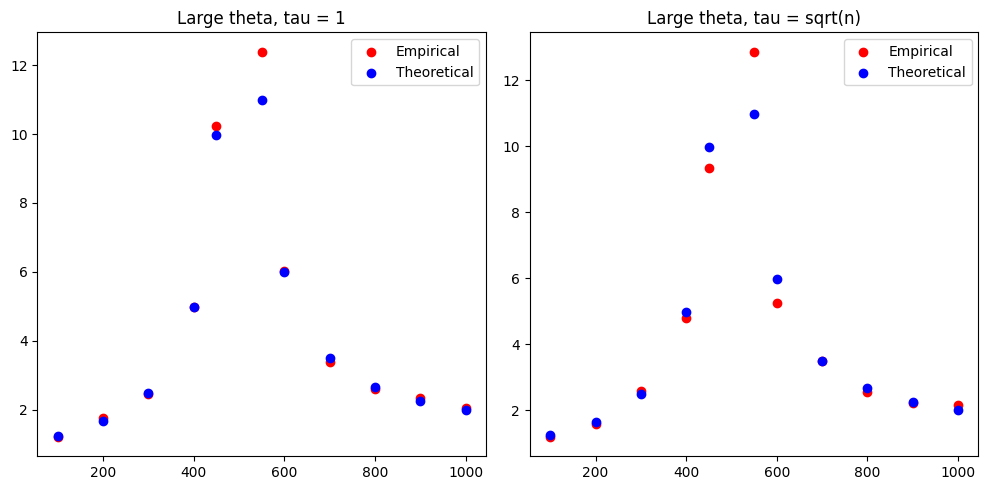

Relative Errors: tensor(0.0466) tensor(0.0409) tensor(0.1474)


In [ ]:
def lem26_emp(n, d, tau, beta_star=None, u=None, T=50):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n,d,tau,tau, beta_star, u)
    avg += torch.norm(vars['beta_star'].T @ vars['Z'] @ vars['Xp'])**2
  return avg/T

def lem26_theory(n,d,tau, beta_star = None, u = None):
  c = d/n
  coeff = (beta_star.T @ u)**2
  theta = np.sqrt(n)*tau
  if c < 1:
    return (((theta**4 + theta**2 * tau**2)/(theta**2 * c + tau**2 )**2) * c**2/(1-c) * coeff).item()
  else:
    return ((theta**2/(theta**2 + tau**2 )) * c/(c-1) * coeff).item()

def lem26_test():
  Ns = [100,200,300,400,450,550,600,700,800,900,1000]
  beta_star = torch.randn(d,1)
  beta_star = beta_star / beta_star.norm()

  u = generate_angle_vector(beta_star.flatten(), 0).view(-1,1)
  u = u / u.norm()

  emp_error, theory_error = test_betaTu(lem26_emp, lem26_theory, Ns=Ns, beta_star = beta_star, u = u, T = 500)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('Large theta, tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('Large theta, tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem26_test()

## Lemma 27

  0%|          | 0/11 [00:00<?, ?it/s]

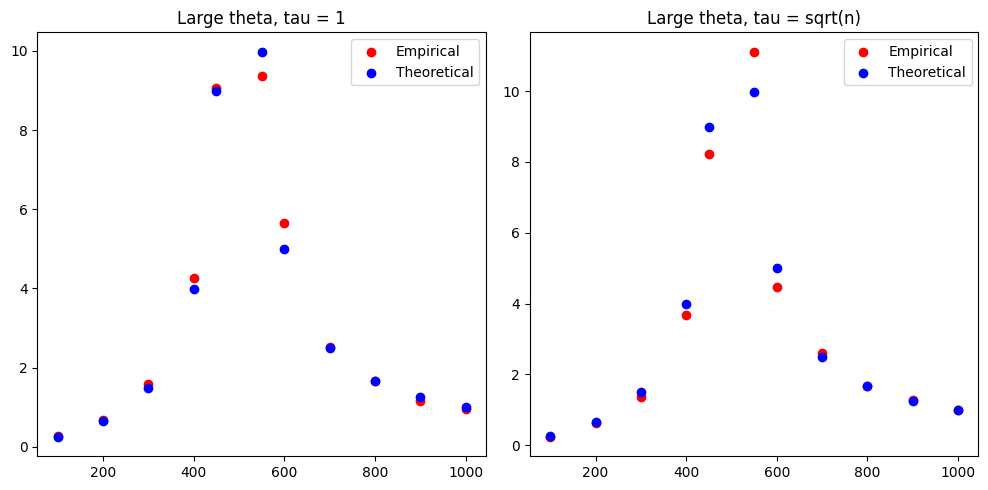

Relative Errors: tensor(0.0602) tensor(0.0380) tensor(0.1204)


In [ ]:
def lem27_emp(n, d, tau, beta_star=None, u=None, T=50):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n,d,tau,tau, beta_star = beta_star, u = u)
    avg += torch.norm(vars['beta_star'].T @ vars['A'] @ vars['Xp'])**2
  return avg/T

def lem27_theory(n,d,tau, beta_star = None, u = None):
  c = d/n
  coeff = (beta_star.T @ u)**2
  theta = np.sqrt(n)*tau
  if c < 1:
    return torch.norm(beta_star)**2 + ( ((theta**4 + theta**2 * tau**2)/(theta**2 * c + tau**2 )**2 * c**2/(1-c)
              - 2 * theta**2 * c/(theta**2 * c + tau**2 ))*coeff).item()
  else:
    return torch.norm(beta_star)**2/c - (theta**2/(theta**2 + tau**2 ) * (torch.norm(beta_star)**2/d - coeff/(c*(c - 1)) ) ).item()

def lem27_test():
  Ns = [100,200,300,400,450,550,600,700,800,900,1000]
  beta_star = torch.randn(d,1)
  beta_star = beta_star / beta_star.norm()

  u = generate_angle_vector(beta_star.flatten(), 0).view(-1,1)
  u = u / u.norm()

  emp_error, theory_error = test_betaTu(lem27_emp, lem27_theory, Ns=Ns, beta_star = beta_star, u = u, T = 5)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('Large theta, tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('Large theta, tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem27_test()

## Lemma 28

  0%|          | 0/11 [00:00<?, ?it/s]

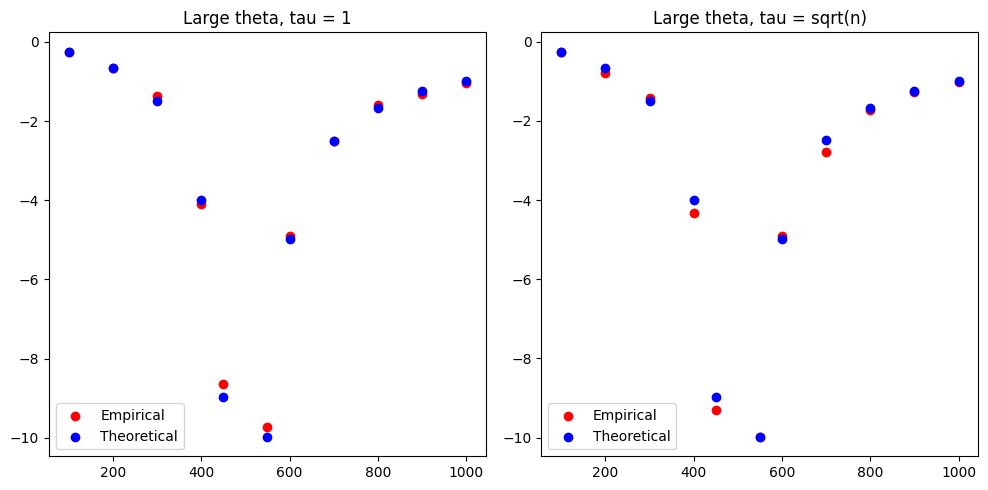

Relative Errors: tensor(-0.0412) tensor(0.0366) tensor(-0.0006)


In [ ]:
def lem28_emp(n, d, tau, beta_star=None, u=None, T=50):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n,d,tau,tau)
    avg += vars['beta_star'].T @ vars['A'] @ vars['Xp'] @ vars['Xp'].T @ vars['Z'].T @ vars['beta_star']
  return avg/T

def lem28_theory(n,d,tau, beta_star = None, u = None):
  c = d/n
  coeff = (beta_star.T @ u)**2
  theta = np.sqrt(n)*tau
  if c < 1:
    return - ( ((theta**4 + theta**2 * tau**2)/(theta**2 * c + tau**2 )**2 * c**2/(1-c) - theta**2*c/(theta**2 * c + tau**2 ) ) * coeff).item()
  else:
    return - (theta**2/(theta**2 + tau**2 ) * ( coeff/(c - 1)) ).item()

def lem28_test():
  Ns = [100,200,300,400,450,550,600,700,800,900,1000]
  beta_star = torch.randn(d,1)
  beta_star = beta_star / beta_star.norm()

  u = generate_angle_vector(beta_star.flatten(), 0).view(-1,1)
  u = u / u.norm()

  emp_error, theory_error = test_betaTu(lem28_emp, lem28_theory, Ns=Ns, beta_star = beta_star, u = u, T = 500)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('Large theta, tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('Large theta, tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem28_test()

## Lemma 29

  0%|          | 0/11 [00:00<?, ?it/s]

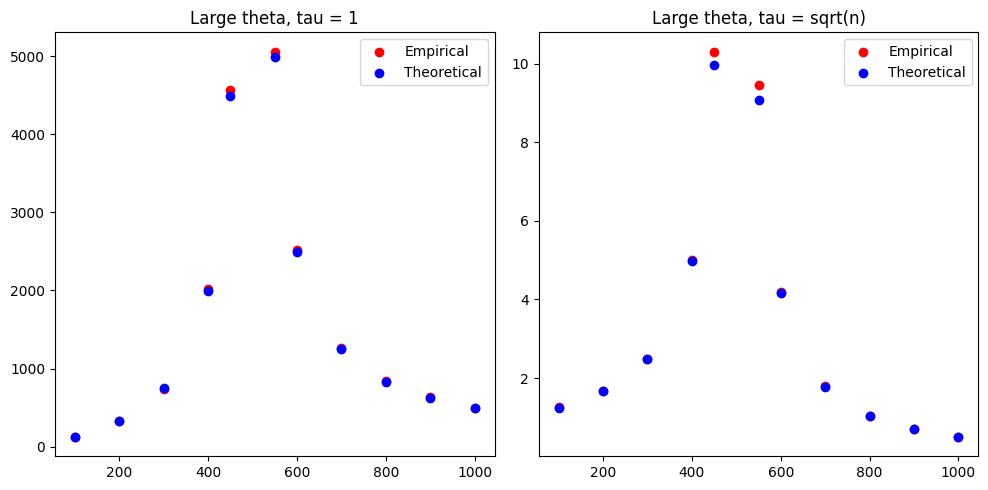

Relative Errors: tensor(0.0104) tensor(0.0100) tensor(0.0419)


In [ ]:
def lem29_emp(n, d, tau, beta_star=None, u=None, T=500):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n,d,tau,tau)
    avg += vars['epsilon'].T  @ vars['Xp'] @ vars['Xp'].T @ vars['epsilon']
  return avg/T

def lem29_theory(n,d,tau, beta_star = None, u = None):
  c = d/n
  theta = np.sqrt(n)*tau
  if c < 1:
    return c*d/(tau**2 * (1-c)) - theta**2 / (tau**2 * (theta**2*c + tau**2)) * c**2 /(1 - c)
  else:
    return d/(tau**2 * (c-1)) - theta**2 / (tau**2 * (theta**2 + tau**2)) * c /(c - 1)

def lem29_test():
  Ns = [100,200,300,400,450,550,600,700,800,900,1000]
  beta_star = torch.randn(d,1)
  beta_star = beta_star / beta_star.norm()

  u = generate_angle_vector(beta_star.flatten(), 0).view(-1,1)
  u = u / u.norm()

  emp_error, theory_error = test(lem29_emp, lem29_theory, Ns=Ns)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('Large theta, tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('Large theta, tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

lem29_test()

# Bias Term

  0%|          | 0/11 [00:00<?, ?it/s]

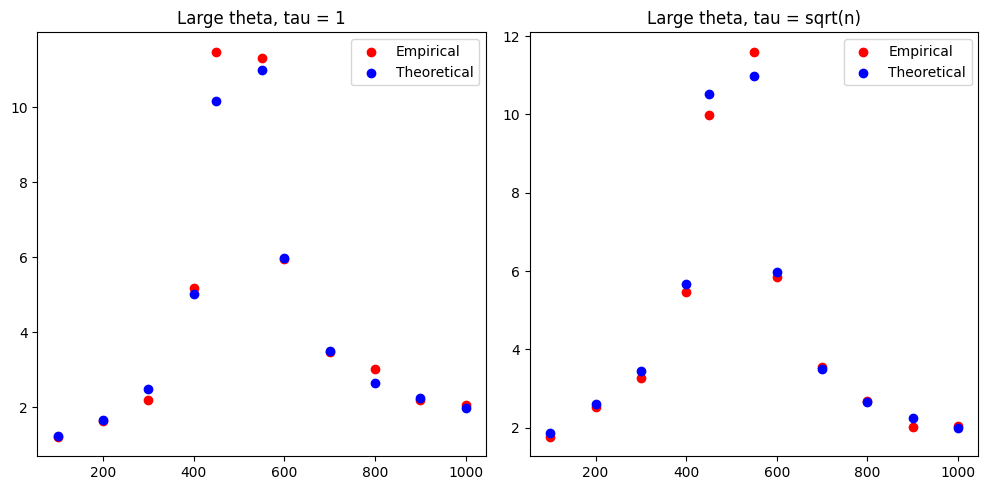

Relative Errors: tensor(0.0460) tensor(0.0395) tensor(0.1360)


In [ ]:
def bias_emp(n, d, tau, beta_star, u, T = 50):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n,d,tau,tau, beta_star = beta_star, u = u)
    bias = lem6_rhs(vars)
    avg += bias.square().sum()
  return avg / T

def bias_theory(n, d, tau, beta_star, u):
  vars = gen_variables(n,d,tau,tau, beta_star = beta_star, u = u)
  c = d/n
  if c < 1:
    den = vars['theta']**2*c+tau**2
    coeff = vars['alpha_Z_t'] - vars['alpha_Z'] +  (tau**2 / den) * (vars['alpha_Z'] - vars['alpha_A'])
    term1 = coeff**2 * (beta_star.T @ u)**2
    term2 = vars['tau_e']**2 * (c/(1-c)) * (1/den)
    term3 = (vars['alpha_Z'] - vars['alpha_A']) ** 2 * (c/(1-c)) * (tau**2/den) * (beta_star.T @ u)**2
    return vars['theta_t'] ** 2 * (term1 + term2 + term3)
    # coeff = vars['alpha_Z_t'] - vars['alpha_Z'] + lem13_1_theory(n,d,tau)/vars['theta'] * (vars['alpha_Z'] - vars['alpha_A'])
    # term1 = coeff**2 * (beta_star.T @ u)**2
    # term2 = vars['tau_e']**2 * (c/(1-c)) * (1/(vars['theta']**2*c+tau**2))
    # return vars['theta_t'] ** 2 * (term1 + term2)
  else:
    den = vars['theta']**2 + tau**2
    theta = np.sqrt(n) * tau
    coeff = vars['alpha_Z_t'] - vars['alpha_Z'] + (tau**2 / den)  * (vars['alpha_Z'] - vars['alpha_A']/c)
    term1 = (coeff**2 + (1/(c-1)) * (theta**2 * tau**2 / (n * den **2)) * (vars['alpha_Z'] - vars['alpha_A']/c)**2) * (beta_star.T @ u)**2
    term2 = vars['tau_e']**2 * ((1/((c-1)) * (theta**2 * c + tau**2) / (theta**2 + tau**2)**2) + ((theta**2 / (n * (theta**2 + tau**2)**2)) * (1/((c-1)**2))))
    term3 = (vars['alpha_A']) ** 2 * (1-1/c) * (beta_star.square().sum()/d) * (tau**2 * vars['theta']**2 / den**2)
    return vars['theta_t'] ** 2 * (term1 + term2 + term3)

def bias_test():
  Ns = [100,200,300,400,450,550,600,700,800,900,1000]
  beta_star = torch.randn(d,1)
  beta_star = beta_star / beta_star.norm()

  u = generate_angle_vector(beta_star.flatten(), 90).view(-1,1)
  u = u / u.norm()

  emp_error, theory_error = test_betaTu(bias_emp, bias_theory, Ns=Ns, beta_star = beta_star, u = u, T = 500)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('Large theta, tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('Large theta, tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

bias_test()

  0%|          | 0/11 [00:00<?, ?it/s]

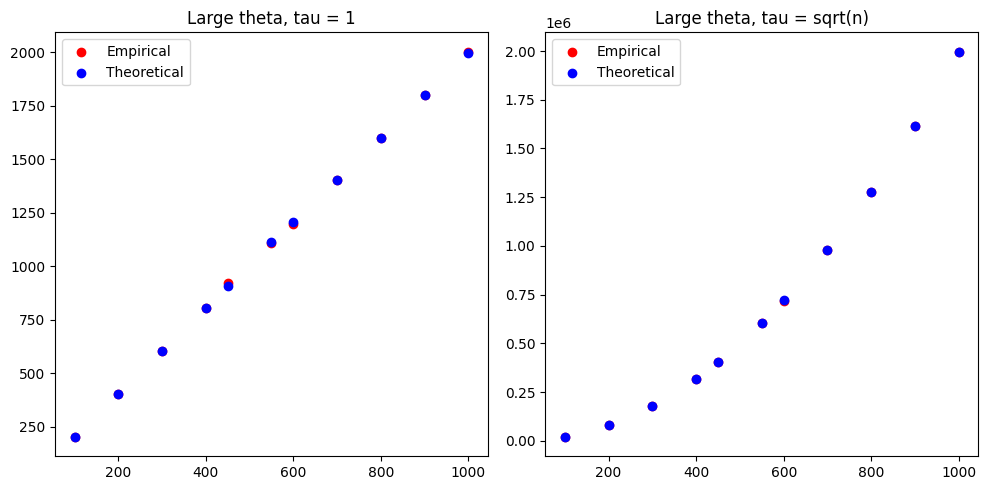

Relative Errors: tensor(0.0027) tensor(0.0034) tensor(0.0143)


In [ ]:
def bias_test():
  Ns = [100,200,300,400,450,550,600,700,800,900,1000]
  beta_star = torch.randn(d,1)
  beta_star = beta_star / beta_star.norm()

  u = generate_angle_vector(beta_star.flatten(), 45).view(-1,1)
  u = u / u.norm()

  emp_error, theory_error = test_betaTu(bias_emp, bias_theory, Ns=Ns, beta_star = beta_star, u = u, T = 500)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('Large theta, tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('Large theta, tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

bias_test()

  0%|          | 0/11 [00:00<?, ?it/s]

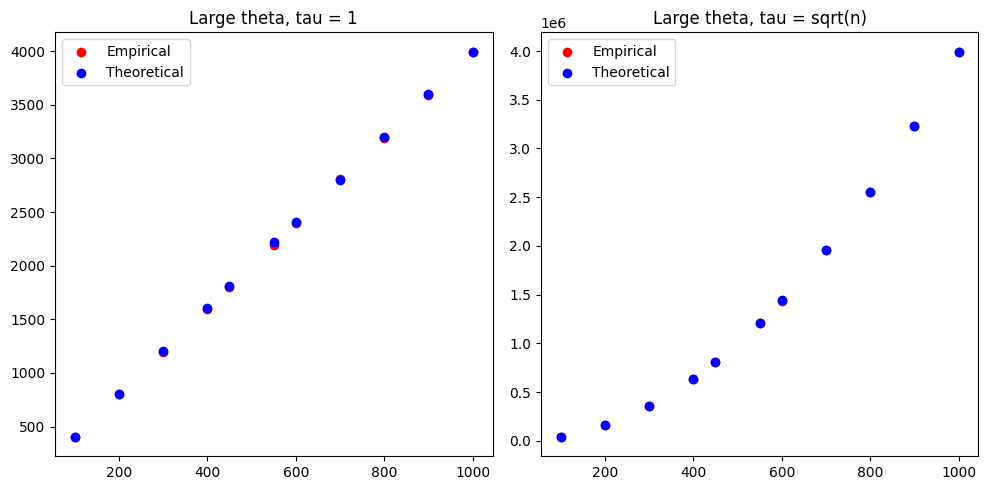

Relative Errors: tensor(0.0020) tensor(0.0027) tensor(0.0126)


In [ ]:
def bias_test():
  Ns = [100,200,300,400,450,550,600,700,800,900,1000]
  beta_star = torch.randn(d,1)
  beta_star = beta_star / beta_star.norm()

  u = generate_angle_vector(beta_star.flatten(), 0).view(-1,1)
  u = u / u.norm()

  emp_error, theory_error = test_betaTu(bias_emp, bias_theory, Ns=Ns, beta_star = beta_star, u = u, T = 500)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('Large theta, tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('Large theta, tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

bias_test()

## Testing each term individually

  0%|          | 0/5 [00:00<?, ?it/s]

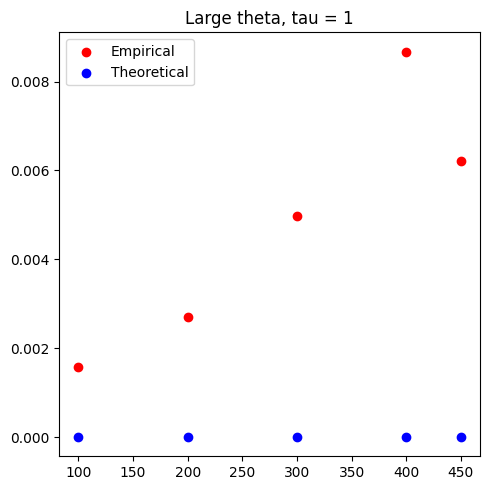

Relative Errors: tensor(1.0000, device='cuda:0') tensor(6.7742e-08, device='cuda:0') tensor(1.0000, device='cuda:0')


In [ ]:
def bias_terms(vars):
  n, d = vars['A'].shape[1], vars['A'].shape[0]
  c = d/n
  beta_star_T = vars['beta_star'].T # shape (1, d)
  if c < 1:
    print("Only for c > 1")
    return 0
  else:
    term1_a = (vars['alpha_Z_t'] - vars['alpha_Z']) * torch.eye(d)
    term1_b = (vars['xi'] / vars['gamma_2']) * (vars['alpha_Z'] * torch.eye(d) - vars['alpha_A'] * vars['A'] @ vars['Ap'])
    term1 = vars['beta_star'].T @ (term1_a + term1_b) @ vars['Z_t']

    term2 = vars['alpha_A'] * vars['theta'] * vars['snorm_sq']/vars['gamma_2'] * vars['beta_star'].T @ vars['h'].T @ vars['u'].T @ vars['Z_t']

    term3 = (vars['theta_t']/vars['theta']) * (vars['xi'] / vars['gamma_2']) * vars['epsilon'].T @ vars['p2'] @ vars['v_t'].T

    # return vars['alpha_Z_t'] * beta_star_T @ vars['Z_t'] - vars['alpha_Z'] * lem4_rhs(vars) - vars['alpha_A'] * lem5_rhs(vars) - vars['epsilon'].T @ lem2_rhs(vars)
    return term1, term2, term3

def bias_terms_theory(n, d, tau, beta_star, u):
  vars = gen_variables(n,d,tau,tau, beta_star = beta_star, u = u)
  c = d/n
  if c < 1:
    print("Only for c > 1")
    return 0
  else:
    theta = np.sqrt(n) * tau
    coeff = vars['alpha_Z_t'] - vars['alpha_Z'] + lem13_2_theory(n,d,tau)/vars['theta']  * (vars['alpha_Z'] - vars['alpha_A']/c)
    term1 = coeff**2 * (beta_star.T @ u)**2
    term2 = vars['tau_e']**2 * lem20_2_theory(n,d,tau) / vars['theta']**2
    term3 = (vars['alpha_A']/theta) ** 2 * lem10_5_theory(n,d,tau,beta_star=beta_star,u=u) * lem16_2_theory(n,d,tau) ** 2
    return vars['theta_t'] ** 2 * term1, vars['theta_t'] ** 2 * term2, vars['theta_t'] ** 2 * term3

def term_1_bias(n,d,tau, beta_star, u,  T = 150):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n,d,tau,tau, beta_star=beta_star, u = u)
    avg += bias_terms(vars)[0].square().sum()
  return avg/T

def term_2_bias(n,d,tau, beta_star, u, T = 150):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n,d,tau,tau, beta_star=beta_star, u = u)
    avg += bias_terms(vars)[1].square().sum()
  return avg/T

def term_3_bias(n,d,tau, beta_star, u,  T = 150):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n,d,tau,tau, beta_star=beta_star, u = u)
    avg += bias_terms(vars)[2].square().sum()
  return avg/T

def term_1_theory(n,d,tau, beta_star, u):
  return bias_terms_theory(n,d,tau, beta_star, u)[0]

def term_2_theory(n,d,tau, beta_star, u):
  return bias_terms_theory(n,d,tau, beta_star, u)[2]

def term_3_theory(n,d,tau, beta_star, u):
  return bias_terms_theory(n,d,tau, beta_star, u)[1]


def test_term1():
  Ns = [100,200,300,400,450]
  beta_star = torch.randn(d,1)
  beta_star = beta_star / beta_star.norm()

  u = generate_angle_vector(beta_star.flatten(), 90).view(-1,1)
  u = u / u.norm()

  emp_error = torch.zeros(len(Ns))
  theory_error = torch.zeros(len(Ns))

  for i, n in tqdm(list(enumerate(Ns))):
    tau = np.sqrt(n)
    emp_error[i] = term_1_bias(n, d, tau,  beta_star, u, T = 150)
    theory_error[i] = term_1_theory(n, d, tau, beta_star, u)

  # emp_error, theory_error = test_betaTu(bias_emp, bias_theory, Ns=Ns, beta_star = beta_star, u = u, T = 500)
  fig, axs = plt.subplots(1, 1, figsize=(5, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs.scatter(Ns, emp_error.cpu(), color = 'red', label='Empirical')
  axs.scatter(Ns, theory_error.cpu(), color = 'blue', label='Theoretical')
  axs.set_title('Large theta, tau = 1')
  axs.legend()

  # # Second subplot
  # axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  # axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  # axs[1].set_title('Large theta, tau = sqrt(n)')
  # axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

test_term1()

  0%|          | 0/5 [00:00<?, ?it/s]

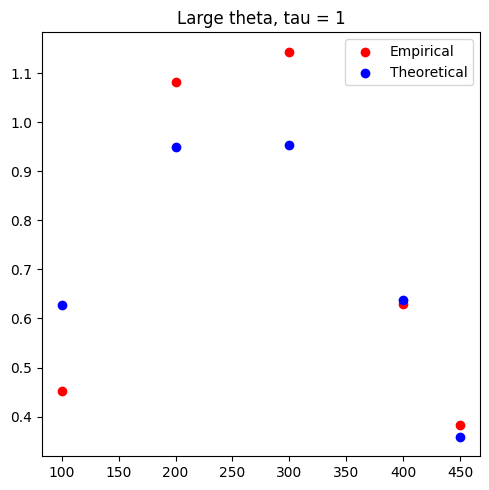

Relative Errors: tensor(0.1493, device='cuda:0') tensor(0.1445, device='cuda:0') tensor(0.3853, device='cuda:0')


In [ ]:
def test_term2():
  Ns = [100,200,300,400,450]
  beta_star = torch.randn(d,1)
  beta_star = beta_star / beta_star.norm()

  u = generate_angle_vector(beta_star.flatten(), 90).view(-1,1)
  u = u / u.norm()

  emp_error = torch.zeros(len(Ns))
  theory_error = torch.zeros(len(Ns))

  for i, n in tqdm(list(enumerate(Ns))):
    tau = np.sqrt(n)
    emp_error[i] = term_2_bias(n, d, tau,  beta_star, u, T = 150)
    theory_error[i] = term_2_theory(n, d, tau, beta_star, u)

  # emp_error, theory_error = test_betaTu(bias_emp, bias_theory, Ns=Ns, beta_star = beta_star, u = u, T = 500)
  fig, axs = plt.subplots(1, 1, figsize=(5, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs.scatter(Ns, emp_error.cpu(), color = 'red', label='Empirical')
  axs.scatter(Ns, theory_error.cpu(), color = 'blue', label='Theoretical')
  axs.set_title('Large theta, tau = 1')
  axs.legend()

  # # Second subplot
  # axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  # axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  # axs[1].set_title('Large theta, tau = sqrt(n)')
  # axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

test_term2()

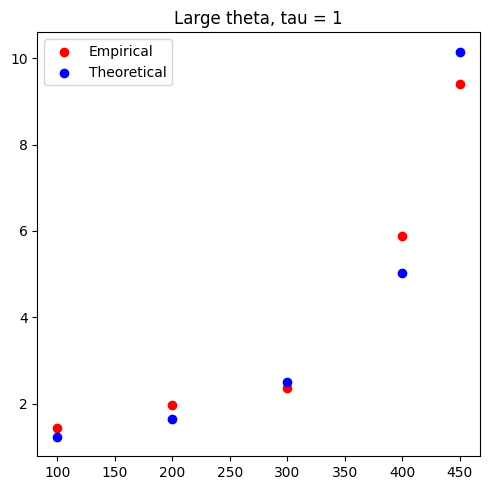

Relative Errors: tensor(0.1184, device='cuda:0') tensor(0.0464, device='cuda:0') tensor(0.1611, device='cuda:0')


In [ ]:
def test_term3():
  Ns = [100,200,300,400,450]
  beta_star = torch.randn(d,1)
  beta_star = beta_star / beta_star.norm()

  u = generate_angle_vector(beta_star.flatten(), 90).view(-1,1)
  u = u / u.norm()

  emp_error = torch.zeros(len(Ns))
  theory_error = torch.zeros(len(Ns))

  for i, n in enumerate(Ns):
    tau = np.sqrt(n)
    emp_error[i] = term_3_bias(n, d, tau, beta_star, u, T = 150)
    theory_error[i] = term_3_theory(n, d, tau, beta_star, u)

  # emp_error, theory_error = test_betaTu(bias_emp, bias_theory, Ns=Ns, beta_star = beta_star, u = u, T = 500)
  fig, axs = plt.subplots(1, 1, figsize=(5, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs.scatter(Ns, emp_error.cpu(), color = 'red', label='Empirical')
  axs.scatter(Ns, theory_error.cpu(), color = 'blue', label='Theoretical')
  axs.set_title('Large theta, tau = 1')
  axs.legend()

  # # Second subplot
  # axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  # axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  # axs[1].set_title('Large theta, tau = sqrt(n)')
  # axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

test_term3()

In [ ]:
def prop_2_emp(vars):
  n, d = vars['A'].shape[1], vars['A'].shape[0]
  c = d/n
  beta_star_T = vars['beta_star'].T # shape (1, d)
  if c < 1:
    print("Only for c > 1")
    return 0
  else:
    term1_a = (vars['alpha_Z_t'] - vars['alpha_Z']) * torch.eye(d)
    term1_b = (vars['xi'] / vars['gamma_2']) * (vars['alpha_Z'] * torch.eye(d) - vars['alpha_A'] * vars['A'] @ vars['Ap'])
    term1 = vars['beta_star'].T @ (term1_a + term1_b) @ vars['Z_t']

    term2 = vars['alpha_A'] * vars['theta'] * vars['snorm_sq']/vars['gamma_2'] * vars['beta_star'].T @ vars['h'].T @ vars['u'].T @ vars['Z_t']

    term3 = (vars['theta_t']/vars['theta']) * (vars['xi'] / vars['gamma_2']) * vars['epsilon'].T @ vars['p2'] @ vars['v_t'].T

    # return vars['alpha_Z_t'] * beta_star_T @ vars['Z_t'] - vars['alpha_Z'] * lem4_rhs(vars) - vars['alpha_A'] * lem5_rhs(vars) - vars['epsilon'].T @ lem2_rhs(vars)
    return vars['beta_star'].T @ vars['A'] @ vars['Ap'] @ vars['Z_t']

# Noise Term

In [ ]:
#Trivial

# Interaction Term

In [ ]:
def target_alignment_emp(n, d, tau, beta_star=None, u=None, T=50):
  """
  Empirical calculation of the target alignment term:
  - (2 * alpha_A_t * tau_A_t^2 / d) * E[beta_star^T @ beta_int]
  Assumes tau_A_t = tau for consistency with other tests.
  """
  avg = 0

  for _ in range(T):
      vars = gen_variables(n, d, tau, tau, beta_star=beta_star, u=u)
      avg += vars['beta_star'].T @ vars['beta_int']
  return avg/T

def target_alignment_theory(n, d, tau, beta_star=None, u=None):
    """
    Theoretical calculation of the target alignment term based on Eq (4) and (5)
    using Lemma 18 and Lemma 19 theoretical results.
    - (2 * alpha_A_t * tau_A_t^2 / d) * E[beta_star^T @ beta_int]
      = - (2 * alpha_A_t * tau_A_t^2 / d) * (alpha_Z * E[lem18] + alpha_A * E[lem19])
    Assumes tau_A_t = tau for consistency with other tests.
    """

    vars = gen_variables(n, d, tau, tau, beta_star=beta_star, u=u)
    c = d/n
    if c < 1:
      return (vars['alpha_Z']-vars['alpha_A']) * (vars['theta']**2 * c)/(tau**2 + vars['theta']**2 * c) * (beta_star.T @ u) ** 2 + vars['alpha_A'] * (beta_star.square().sum())
    else:
      return (vars['alpha_Z']-vars['alpha_A']/c) * (vars['theta']**2)/(tau**2 + vars['theta']**2) * (beta_star.T @ u) ** 2 + vars['alpha_A'] * (beta_star.square().sum()) * (1/c - vars['theta']**2/(d * (vars['theta']**2 + tau**2)))


def target_alignment_test():
  """
  Tests the Target Alignment term calculation.
  """
  Ns = [100,200,300,400,450,550,600,700,800,900,1000]
  d_fixed = 500 # Keep d fixed as per existing tests

  beta_star = torch.randn(d_fixed, 1, device=torch.get_default_device())
  beta_star = beta_star / beta_star.norm()

  # Test case 1: u aligned with beta_star
  print("--- Target Alignment Test (u aligned with beta_star) ---")
  u_aligned = beta_star.clone()
  emp_error_aligned, theory_error_aligned = test_betaTu(target_alignment_emp, target_alignment_theory, Ns=Ns, d=d_fixed, beta_star=beta_star, u=u_aligned, T=500) # Increased T for stability

  fig, axs = plt.subplots(1, 2, figsize=(12, 5))
  axs[0].scatter(Ns, emp_error_aligned[:,0], color = 'red', label='Empirical (tau=1)')
  axs[0].plot(Ns, theory_error_aligned[:,0], color = 'blue', label='Theoretical (tau=1)', linestyle='--')
  axs[0].set_title('Target Alignment (tau=1, u aligned)')
  axs[0].set_xlabel('n')
  axs[0].set_ylabel('Term Value')
  axs[0].legend()
  axs[0].grid(True)

  axs[1].scatter(Ns, emp_error_aligned[:,1], color = 'red', label='Empirical (tau=sqrt(n))')
  axs[1].plot(Ns, theory_error_aligned[:,1], color = 'blue', label='Theoretical (tau=sqrt(n))', linestyle='--')
  axs[1].set_title('Target Alignment (tau=sqrt(n), u aligned)')
  axs[1].set_xlabel('n')
  axs[1].set_ylabel('Term Value')
  axs[1].legend()
  axs[1].grid(True)

  plt.suptitle('Target Alignment Term: Empirical vs Theoretical (u aligned)')
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
  plt.show()

  rel_errors = (emp_error_aligned-theory_error_aligned).abs()/(emp_error_aligned)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

  # Test case 2: u orthogonal to beta_star
  print("\n--- Target Alignment Test (u orthogonal to beta_star) ---")
  u_ortho = generate_angle_vector(beta_star.flatten(), 90).view(-1, 1) # Use existing function

  emp_error_ortho, theory_error_ortho = test_betaTu(target_alignment_emp, target_alignment_theory, Ns=Ns, d=d_fixed, beta_star=beta_star, u=u_ortho, T=500) # Increased T for stability

  fig, axs = plt.subplots(1, 2, figsize=(12, 5))
  axs[0].scatter(Ns, emp_error_ortho[:,0], color = 'red', label='Empirical (tau=1)')
  axs[0].plot(Ns, theory_error_ortho[:,0], color = 'blue', label='Theoretical (tau=1)', linestyle='--')
  axs[0].set_title('Target Alignment (tau=1, u orthogonal)')
  axs[0].set_xlabel('n')
  axs[0].set_ylabel('Term Value')
  axs[0].legend()
  axs[0].grid(True)


  axs[1].scatter(Ns, emp_error_ortho[:,1], color = 'red', label='Empirical (tau=sqrt(n))')
  axs[1].plot(Ns, theory_error_ortho[:,1], color = 'blue', label='Theoretical (tau=sqrt(n))', linestyle='--')
  axs[1].set_title('Target Alignment (tau=sqrt(n), u orthogonal)')
  axs[1].set_xlabel('n')
  axs[1].set_ylabel('Term Value')
  axs[1].legend()
  axs[1].grid(True)

  plt.suptitle('Target Alignment Term: Empirical vs Theoretical (u orthogonal)')
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
  plt.show()

  rel_errors = (emp_error_ortho-theory_error_ortho).abs()/(emp_error_ortho)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())


--- Target Alignment Test (u aligned with beta_star) ---


  0%|          | 0/11 [00:00<?, ?it/s]

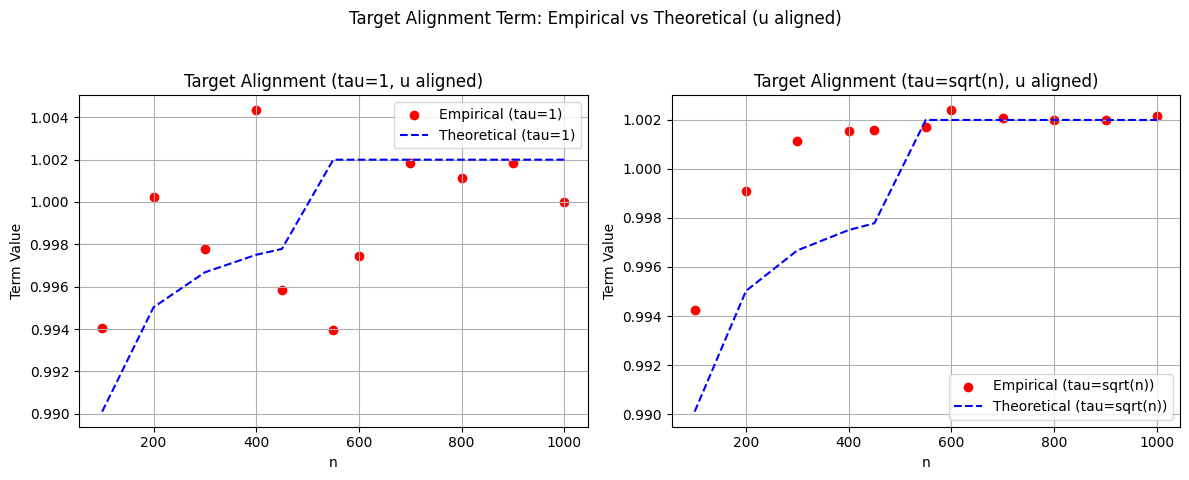

Relative Errors: tensor(0.0026) tensor(0.0024) tensor(0.0081)

--- Target Alignment Test (u orthogonal to beta_star) ---


  0%|          | 0/11 [00:00<?, ?it/s]

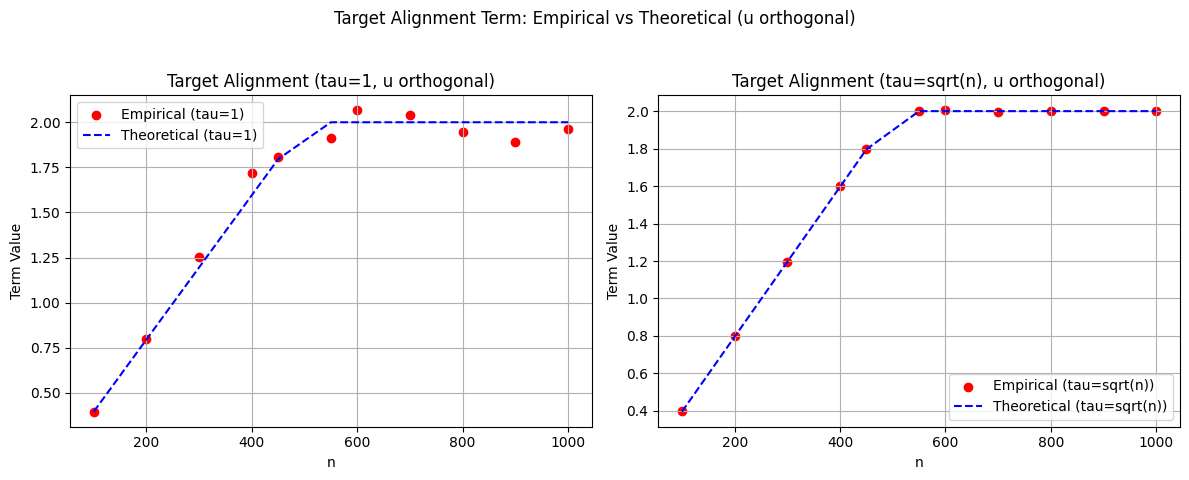

Relative Errors: tensor(0.0162) tensor(0.0215) tensor(0.0729)


In [ ]:
target_alignment_test()

# Variance Term

In [ ]:
def lem26_theory(n,d,tau, beta_star = None, u = None):
  c = d/n
  coeff = (beta_star.T @ u)**2
  theta = np.sqrt(n)*tau
  if c < 1:
    return (((theta**4 + theta**2 * tau**2)/(theta**2 * c + tau**2 )**2) * c**2/(1-c) * coeff).item()
  else:
    return ((theta**2/(theta**2 + tau**2 )) * c/(c-1) * coeff).item()

def lem26_emp(n, d, tau, beta_star=None, u=None, T=50):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n,d,tau,tau, beta_star, u)
    avg += torch.norm(vars['beta_star'].T @ vars['Z'] @ vars['Xp'])**2
  return avg/T

def lem27_theory(n,d,tau, beta_star = None, u = None):
  c = d/n
  coeff = (beta_star.T @ u)**2
  theta = np.sqrt(n)*tau
  if c < 1:
    return torch.norm(beta_star)**2 + ( ((theta**4 + theta**2 * tau**2)/(theta**2 * c + tau**2 )**2 * c**2/(1-c)
              - 2 * theta**2 * c/(theta**2 * c + tau**2 ))*coeff).item()
  else:
    return torch.norm(beta_star)**2/c - (theta**2/(theta**2 + tau**2 ) * (torch.norm(beta_star)**2/d - coeff/(c*(c - 1)) ) ).item()

def lem27_emp(n, d, tau, beta_star=None, u=None, T=50):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n,d,tau,tau, beta_star = beta_star, u = u)
    avg += torch.norm(vars['beta_star'].T @ vars['A'] @ vars['Xp'])**2
  return avg/T

def lem28_theory(n,d,tau, beta_star = None, u = None):
  c = d/n
  coeff = (beta_star.T @ u)**2
  theta = np.sqrt(n)*tau
  if c < 1:
    return - ( ((theta**4 + theta**2 * tau**2)/(theta**2 * c + tau**2 )**2 * c**2/(1-c) - theta**2*c/(theta**2 * c + tau**2 ) ) * coeff).item()
  else:
    return - (theta**2/(theta**2 + tau**2 ) * ( coeff/(c - 1)) ).item()

def lem28_emp(n, d, tau, beta_star=None, u=None, T=50):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n,d,tau,tau)
    avg += vars['beta_star'].T @ vars['A'] @ vars['Xp'] @ vars['Xp'].T @ vars['Z'].T @ vars['beta_star']
  return avg/T

def lem29_theory(n,d,tau, beta_star = None, u = None):
  c = d/n
  theta = np.sqrt(n)*tau
  if c < 1:
    return c*d/(tau**2 * (1-c)) - theta**2 / (tau**2 * (theta**2*c + tau**2)) * c**2 /(1 - c)
  else:
    return d/(tau**2 * (c-1)) - theta**2 / (tau**2 * (theta**2 + tau**2)) * c /(c - 1)

def lem29_emp(n, d, tau, beta_star=None, u=None, T=500):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n,d,tau,tau)
    avg += vars['epsilon'].T  @ vars['Xp'] @ vars['Xp'].T @ vars['epsilon']
  return avg/T

In [ ]:
def var_emp_LHS(n, d, tau, beta_star, u, T = 50):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n,d,tau,tau, beta_star = beta_star, u = u)
    variance = 1/n * torch.norm(vars['beta_int'].T @ vars['A_t'])**2
    avg += variance / T
  return avg

def var_emp_RHS(n, d, tau, beta_star, u, T = 50):
  avg = 0
  for _ in range(T):
    vars = gen_variables(n,d,tau,tau, beta_star = beta_star, u = u)
    variance = 1/n * torch.norm(vars['beta_int'].T @ vars['A_t'])**2
    avg += vars['tau_A']**2/d *  (
      vars['alpha_Z']**2 * torch.norm(vars['beta_star'].T @ vars['Z'] @ vars['Xp'])**2 +
      vars['alpha_A']**2 * torch.norm(vars['beta_star'].T @ vars['A'] @ vars['Xp'])**2 +
      2*vars['alpha_A']*vars['alpha_Z']*vars['beta_star'].T @ vars['A'] @ vars['Xp'] @ vars['Xp'].T @ vars['Z'].T @ vars['beta_star'] +
      vars['epsilon'].T  @ vars['Xp'] @ vars['Xp'].T @ vars['epsilon']
  ) / T
  return avg

def var_theory(n, d, tau, beta_star, u):
  vars = gen_variables(n,d,tau,tau, beta_star = beta_star, u = u)
  c = d/n

  return vars['tau_A']**2/d * (
      vars['alpha_Z']**2 * lem26_theory(n,d,tau,beta_star=beta_star,u=u) +
      vars['alpha_A']**2 * lem27_theory(n,d,tau,beta_star=beta_star,u=u) +
      2*vars['alpha_A']*vars['alpha_Z']*lem28_theory(n,d,tau,beta_star=beta_star,u=u) +
      vars['tau_e']**2 * lem29_theory(n,d,tau,beta_star=beta_star,u=u)
  )
  #if c < 1:
  #  coeff = vars['alpha_Z_t'] - vars['alpha_Z'] + lem13_1_theory(n,d,tau)/vars['theta'] * (vars['alpha_Z'] - vars['alpha_A'])
  #  term1 = coeff**2 * (beta_star.T @ u)**2
  #  term2 = vars['tau_e']**2 * lem20_1_theory(n,d,tau) / vars['theta']**2
  #  return vars['theta_t'] ** 2 * (term1 + term2)
  #else:
  #  theta = np.sqrt(n) * tau
  #  coeff = vars['alpha_Z_t'] - vars['alpha_Z'] + lem13_2_theory(n,d,tau)/vars['theta']  * (vars['alpha_Z'] - vars['alpha_A']/c)
  #  term1 = coeff**2 * (beta_star.T @ u)**2
  #  term2 = vars['tau_e']**2 * lem20_2_theory(n,d,tau) / vars['theta']**2
  #  term3 = (vars['alpha_A']/theta) ** 2 * lem10_5_theory(n,d,tau,beta_star=beta_star,u=u) * lem16_2_theory(n,d,tau) ** 2
  #  return vars['theta_t'] ** 2 * (term1 + term2 + term3)

def var_test():
  Ns = [100,200,300,400,450,550,600,700,800,900,1000]
  beta_star = torch.randn(d,1)
  beta_star = beta_star / beta_star.norm()

  u = generate_angle_vector(beta_star.flatten(), 90).view(-1,1)
  u = u / u.norm()

  emp_error, theory_error = test_betaTu(var_emp_RHS, var_theory, Ns=Ns, beta_star = beta_star, u = u, T = 500)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('Large theta, tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('Large theta, tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

var_test()

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

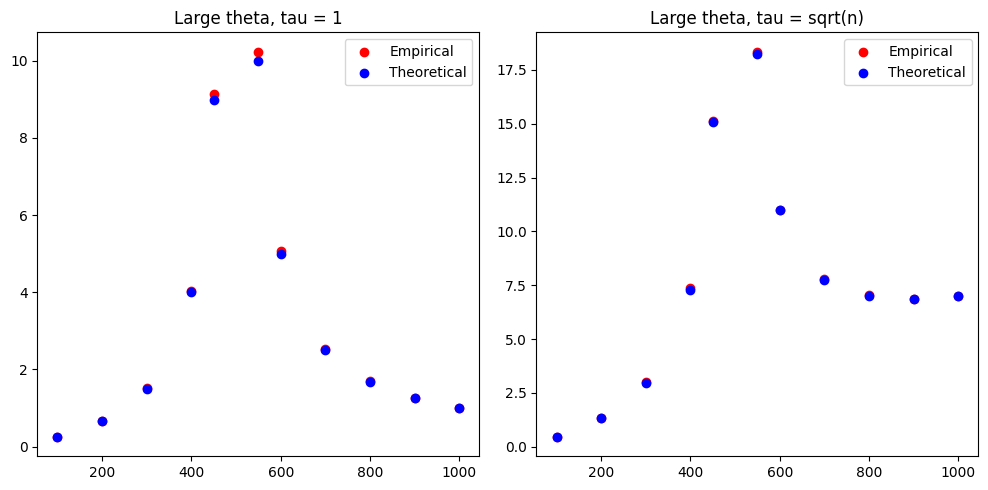

Relative Errors: tensor(0.0079) tensor(0.0059) tensor(0.0238)


In [ ]:
def var_test():
  Ns = [100,200,300,400,450,550,600,700,800,900,1000]
  beta_star = torch.randn(d,1)
  beta_star = beta_star / beta_star.norm()

  u = generate_angle_vector(beta_star.flatten(), 45).view(-1,1)
  u = u / u.norm()

  emp_error, theory_error = test_betaTu(var_emp_LHS, var_theory, Ns=Ns, beta_star = beta_star, u = u, T = 500)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('Large theta, tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('Large theta, tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

var_test()

  0%|          | 0/11 [00:00<?, ?it/s]

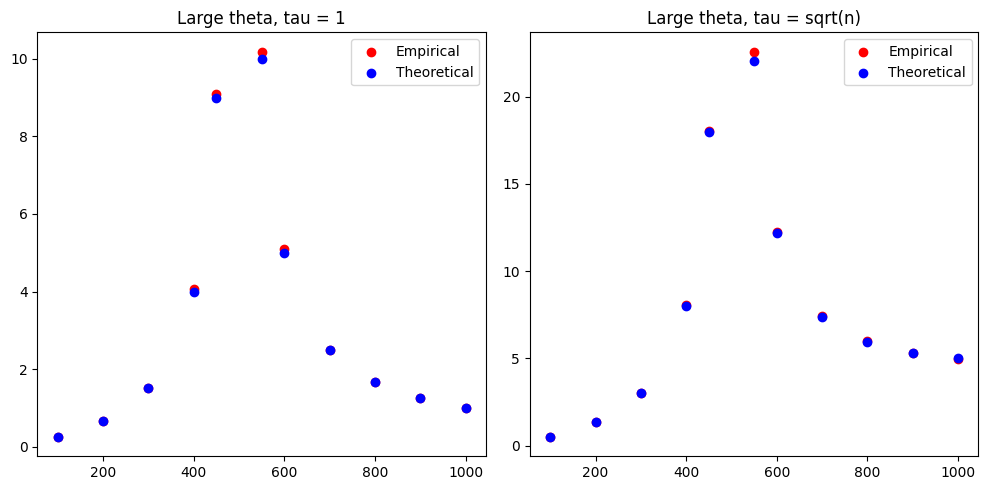

Relative Errors: tensor(0.0071) tensor(0.0063) tensor(0.0226)


In [ ]:
def var_test():
  Ns = [100,200,300,400,450,550,600,700,800,900,1000]
  beta_star = torch.randn(d,1)
  beta_star = beta_star / beta_star.norm()

  u = generate_angle_vector(beta_star.flatten(), 0).view(-1,1)
  u = u / u.norm()

  emp_error, theory_error = test_betaTu(var_emp_LHS, var_theory, Ns=Ns, beta_star = beta_star, u = u, T = 500)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

  # First subplot
  axs[0].scatter(Ns, emp_error[:,0], color = 'red', label='Empirical')
  axs[0].scatter(Ns, theory_error[:,0], color = 'blue', label='Theoretical')
  axs[0].set_title('Large theta, tau = 1')
  axs[0].legend()

  # Second subplot
  axs[1].scatter(Ns, emp_error[:,1], color = 'red', label='Empirical')
  axs[1].scatter(Ns, theory_error[:,1], color = 'blue', label='Theoretical')
  axs[1].set_title('Large theta, tau = sqrt(n)')
  axs[1].legend()

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

  rel_errors = (emp_error-theory_error).abs()/(emp_error)

  print("Relative Errors:", rel_errors.mean(), rel_errors.std(), rel_errors.max())

var_test()